<a id='initialisation'></a>
___
___
## <font color='coral'>**Appel de l'environment** </font> [▲](#sommaire)

In [0]:
%reset -f
import ipywidgets as widgets
%matplotlib widget

## For GPU optimization
# import cupy as np
# from cupyx.scipy.ndimage import uniform_filter1d

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from IPython.display import clear_output

## For sliders
from ipywidgets import Layout, interact

## Set up rc
plt.rcParams['image.cmap'] = 'RdYlBu_r'
plt.rcParams['axes.formatter.limits'] = (-3,1)
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams.update({"axes.grid" : True})
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.markeredgewidth'] = 2.0
plt.rc('font',size=18)
me = (0.1,0.1) #Markevery

#Size of figures
dpi_laptop = 50; dpi_cadarache = 65; dpi_home = 100
dpi_custom = dpi_home

## Set colors
import seaborn as sns
palette = ["bright", "dark", "deep", "muted", "pastel", "colorblind"]

## Checkbox to select which simulations to plot
original_sim       = widgets.Checkbox(value=False,description='Original simulation',layout=Layout(width='50%'))
neoclassical_sim   = widgets.Checkbox(value=False,description='Neoclassical simulation',layout=Layout(width='50%'))
firstphase_newsim  = widgets.Checkbox(value=False,description='First phase of new simulation',layout=Layout(width='50%'))
secondphase_newsim = widgets.Checkbox(value=True,description='Second phase of new simulation',layout=Layout(width='50%'))
test_aligned_GC7   = widgets.Checkbox(value=True,description='Test - Aligned coordinate with 7 points for gyroavg',layout=Layout(width='50%'))

display(original_sim,neoclassical_sim,firstphase_newsim,secondphase_newsim,test_aligned_GC7)

## 
wished_values = ['As', 'Zs', 
                 'Gamma_vD', 'Gamma_vE',
                 'Isq', 'dIsqdr',
                 'ns0','Ts0','n','T', 'Pperp',
                 'RSpol', 'RSpol_vD', 'RSpol_vE',
                 'VP', 'VT', 'Phi00', 'PhiFSavg', 'Er', 'Er_00',
                 'nu_i', 'nustar', 'vorticity', 'P',
                 'rho', 'time', 'q', 'rg']

untreated_values = ['spreading_0deg', 'spreading_180deg', 'spreading_270deg', 'spreading_90deg', 'spreading_FSavg', 
                    'nIturbGC_FSavg', 'IturbGC_FSavg','dIdr' 'delta_n_avg', 'Ppar',
                    'Qpar_vD', 'Qpar_vE', 'Qpar_vEn0', 'Qperp_vD', 'Qperp_vE', 'Qperp_vEn0', 'Qtot', 'Qtot_vD', 'Qtot_vE', 'Qtot_vEn0',
                    'RSphi', 'RSphi_vD', 'RSphi_vE', 'RSphi_vEn0',
                    'RSpol_vEn0',
                    'Gamma_vEn0',
                    'eps']


Checkbox(value=False, description='Original simulation', layout=Layout(width='50%'))

Checkbox(value=False, description='Neoclassical simulation', layout=Layout(width='50%'))

Checkbox(value=False, description='First phase of new simulation', layout=Layout(width='50%'))

Checkbox(value=True, description='Second phase of new simulation', layout=Layout(width='50%'))

Checkbox(value=True, description='Test - Aligned coordinate with 7 points for gyroavg', layout=Layout(width='5…

<a id='chargement_donnees'></a>
## <font color='coral'>**Chargement des données** </font> [▲](#sommaire)

In [1]:
class mydict(dict):
    def __init__(self, *args, **kwargs):
        super(mydict, self).__init__(*args, **kwargs)
        self.__dict__ = self

    def __getitem__(self, key): 
        if  key[:2] == 'dr'               : return np.gradient(self[key[2:]], self['rg'], axis=1)
        if  key[:2] == 'dt'               : return np.gradient(self[key[2:]], self['time'], axis=0)
        if  key     == 'P'                : return -self['As'] * (- self['ns0'] * self['Er'] + 0.5 * self['Zs']**(-1) * self['drPperp'])
        if  key     == 'vorticity'        : return self['drP']
        if  key     == 'Ptransfert'       : return self['drRSpol_vE'] * (-self['Er'])
        if  key     == 'Ptransfert_approx': return self['RSpol_vE'] * (-self['drEr'])
        if  key     == 'Jr'               : return self['As']*(self['Gamma_vE'] + self['Gamma_vD'])
        #q['Ptransfert_w_prefactor']  = -q['dRSpoldr'] * (-q['Er']) / (1 + 2 * q['q']**2)
        #q['Ptransfert_withdia']      = -q['dRSpol_tot_from3Ddr'] * (-q['Er'])
        else: return super().__getitem__(key)

def hdf5_to_dict(filename):
    """Load a dictionary of arrays and strings as unicode characters from an HDF5 file."""
    with h5py.File(filename, 'r') as f:
        d = {}
        for k in f.keys():
            if k not in untreated_values:
                v = f[k][()]
                if isinstance(v, bytes):d[k] = v.decode('utf-8')
                else:d[k] = np.array(v)
    return mydict(d)

all_sim = []
# First simulations
if original_sim.value:
    qprof_05 = hdf5_to_dict('data/TS45511_q05.hdf5'); qprof_05['title'] = r'$q_{ref} \times 0.5$'; qprof_05['c'] = sns.color_palette(palette[2])[0]; qprof_05['c2'] = sns.color_palette(palette[5])[0]
    qprof_1  = hdf5_to_dict('data/TS45511_q1.hdf5') ; qprof_1['title']  = r'$q_{ref}$'           ; qprof_1['c']  = sns.color_palette(palette[2])[2]; qprof_1['c2']  = sns.color_palette(palette[5])[2]        
    qprof_15 = hdf5_to_dict('data/TS45511_q15.hdf5'); qprof_15['title'] = r'$q_{ref} \times 1.5$'; qprof_15['c'] = sns.color_palette(palette[2])[3]; qprof_15['c2'] = sns.color_palette(palette[5])[3]
    all_sim.extend([qprof_05,qprof_1,qprof_15])

# Simulations without turbulence, only toroidal n=0 mode kept
if neoclassical_sim.value:
    qprof_05_n0 = hdf5_to_dict('data/TS45511_q05_n0.hdf5'); qprof_05_n0['title']=r'$q_{ref} \times 0.5$ - $n=0$'; qprof_05_n0['c']  = sns.color_palette(palette[1])[0]; qprof_05_n0['c2']  = sns.color_palette(palette[4])[0]
    qprof_15_n0 = hdf5_to_dict('data/TS45511_q15_n0.hdf5'); qprof_15_n0['title']=r'$q_{ref} \times 1.5$ - $n=0$'; qprof_15_n0['c']  = sns.color_palette(palette[1])[3]; qprof_15_n0['c2']  = sns.color_palette(palette[4])[3]
    all_sim.extend([qprof_05_n0,qprof_15_n0])

# Redo of first simulations with better time resolution - 1st phase
if firstphase_newsim.value:
    qprof_05_br  = hdf5_to_dict('data/TS45511_q05_br.hdf5') ; qprof_05_br['title'] =r'$q_{ref}^{BR} \times 0.5$' ; qprof_05_br['c']  = sns.color_palette(palette[0])[0]; qprof_05_br['c2']  = sns.color_palette(palette[3])[0]
    qprof_075_br = hdf5_to_dict('data/TS45511_q075_br.hdf5'); qprof_075_br['title']=r'$q_{ref}^{BR} \times 0.75$'; qprof_075_br['c'] = sns.color_palette(palette[0])[1]; qprof_075_br['c2'] = sns.color_palette(palette[3])[1]
    qprof_15_br  = hdf5_to_dict('data/TS45511_q15_br.hdf5') ; qprof_15_br['title'] =r'$q_{ref}^{BR} \times 1.5$' ; qprof_15_br['c']  = sns.color_palette(palette[0])[3]; qprof_15_br['c2']  = sns.color_palette(palette[3])[3]
    qprof_05_alignedGC7  = hdf5_to_dict('data/TS45511_q05_aligned_GC7.hdf5') ; qprof_05_alignedGC7['title'] = r'$q_{ref}^{align} \times 0.5$' ; qprof_05_alignedGC7['c']='xkcd:green' ; qprof_05_alignedGC7['c2']='xkcd:lime'  ; qprof_05_alignedGC7['ls']='-'
    all_sim.extend([qprof_05_br,qprof_075_br,qprof_15_br,qprof_05_alignedGC7])

# Redo of first simulations with better time resolution - 2nd phase
if secondphase_newsim.value:
    qprof_05_br_2ndphase  = hdf5_to_dict('data/TS45511_q05_br_secondphase.hdf5') ; qprof_05_br_2ndphase['title'] =r'$q_{ref}^{BR,2nd} \times 0.5$' ; qprof_05_br_2ndphase['c']='xkcd:blue' ; qprof_05_br_2ndphase['c']  = sns.color_palette(palette[0])[0]; qprof_05_br_2ndphase['c2']  = sns.color_palette(palette[3])[0]
    qprof_075_br_2ndphase = hdf5_to_dict('data/TS45511_q075_br_secondphase.hdf5'); qprof_075_br_2ndphase['title']=r'$q_{ref}^{BR,2nd} \times 0.75$'; qprof_075_br_2ndphase['c']='xkcd:pink'; qprof_075_br_2ndphase['c'] = sns.color_palette(palette[0])[1]; qprof_075_br_2ndphase['c2'] = sns.color_palette(palette[3])[1]
    qprof_15_br_2ndphase  = hdf5_to_dict('data/TS45511_q15_br_secondphase.hdf5') ; qprof_15_br_2ndphase['title'] =r'$q_{ref}^{BR,2nd} \times 1.5$' ; qprof_15_br_2ndphase['c']='xkcd:red'  ; qprof_15_br_2ndphase['c']  = sns.color_palette(palette[0])[3]; qprof_15_br_2ndphase['c2']  = sns.color_palette(palette[3])[3]
    qprof_05_br_2ndphase['RSdia']  = np.load('data/q05_RSdia_FSavg.npy')[:-1,:] ; qprof_05_br_2ndphase['RSpol_vE_from3D']  = np.load('data/q05_RSelec_FSavg.npy')[:-1,:] ; qprof_05_br_2ndphase['RSpol_tot_from3D']  = qprof_05_br_2ndphase['RSdia'] + qprof_05_br_2ndphase['RSpol_vE_from3D']
    qprof_075_br_2ndphase['RSdia'] = np.load('data/q075_RSdia_FSavg.npy')[:-1,:]; qprof_075_br_2ndphase['RSpol_vE_from3D'] = np.load('data/q075_RSelec_FSavg.npy')[:-1,:]; qprof_075_br_2ndphase['RSpol_tot_from3D'] = qprof_075_br_2ndphase['RSdia'] + qprof_075_br_2ndphase['RSpol_vE_from3D']
    qprof_15_br_2ndphase['RSdia']  = np.load('data/q15_RSdia_FSavg.npy')[:-1,:] ; qprof_15_br_2ndphase['RSpol_vE_from3D']  = np.load('data/q15_RSelec_FSavg.npy')[:-1,:] ; qprof_15_br_2ndphase['RSpol_tot_from3D']  = qprof_15_br_2ndphase['RSdia'] + qprof_15_br_2ndphase['RSpol_vE_from3D']
    all_sim.extend([qprof_05_br_2ndphase,qprof_075_br_2ndphase,qprof_15_br_2ndphase])

# Test with aligned coordinates and 7 points for the gyroaverage
if test_aligned_GC7.value:
    qprof_05_br          = hdf5_to_dict('data/TS45511_q05_br.hdf5')          ; qprof_05_br['title']         = r'$q_{ref}^{BR} \times 0.5$'    ; qprof_05_br['c']='xkcd:blue'          ; qprof_05_br['c2']='xkcd:azure'         ; qprof_05_br['ls']='-'
    qprof_05_alignedGC7  = hdf5_to_dict('data/TS45511_q05_aligned_GC7.hdf5') ; qprof_05_alignedGC7['title'] = r'$q_{ref}^{align} \times 0.5$' ; qprof_05_alignedGC7['c']='xkcd:green' ; qprof_05_alignedGC7['c2']='xkcd:lime'  ; qprof_05_alignedGC7['ls']='-'
    qprof_05_GC7         = hdf5_to_dict('data/TS45511_q05_GC7.hdf5')         ; qprof_05_GC7['title']        = r'$q_{ref}^{GC7} \times 0.5$'   ; qprof_05_GC7['c']='xkcd:red'          ; qprof_05_GC7['c2']='xkcd:light red'    ; qprof_05_GC7['ls']='-'
    qprof_05_n0          = hdf5_to_dict('data/TS45511_q05_n0.hdf5')          ; qprof_05_n0['title']         = r'$q_{ref} \times 0.5$ - $n=0$' ; qprof_05_n0['c']='xkcd:bright orange' ; qprof_05_n0['c2']='xkcd:vermillion'    ; qprof_05_n0['ls']='-'
    all_sim.extend([qprof_05_br,qprof_05_alignedGC7,qprof_05_n0,qprof_05_GC7])

print(all_sim[0].keys())

## Add markers entry to each dictionnary
marker_ar = ['o', 's', 'v', 'D', 'P', 'X', 'd', 'p', 'x']
for iq,q in enumerate(all_sim):
    q['marker'] = marker_ar[iq]
    
## Estimation of the memory usage of the dictionnaries in all_sim
mem_usage = 0
for q in all_sim:
    for p in q.keys():
        if type(q[p]) is np.ndarray:
            mem_usage += q[p].nbytes
print('Memory usage of all_sim = %s MB' % (mem_usage/1024/1024))

## Definintion of custom widgets used in interactive plots
custom_widgets = {'dpi_adjust' : widgets.IntSlider(min=30, max=200, step=1,value=dpi_custom, continuous_update=False),
                  'N'          : widgets.IntSlider(min=1, max=100, step=1,value=1, continuous_update=False), 
                  'select_sim' : widgets.SelectMultiple(options=[q['title'] for q in all_sim], value=[q['title'] for q in [all_sim[0], all_sim[-1]]], description='Simulations'), 
                  'param'      : widgets.Text(value='Er',placeholder='Type something',description='Select parameter:', continuous_update=False),
                  'param2'     : widgets.Text(value='',placeholder='Type something',description='Select parameter:', continuous_update=False)}


dict_keys(['As', 'Er', 'Er_00', 'Gamma_vD', 'Gamma_vE', 'Gamma_vEndiff0', 'Isq', 'Phi00', 'PhiFSavg', 'Pperp', 'RSpol_vD', 'RSpol_vE', 'T', 'Ts0', 'VP', 'VT', 'Zs', 'delta_n_avg', 'n', 'ns0', 'nu_i', 'nustar', 'q', 'rg', 'rho', 'time', 'title', 'c', 'c2', 'ls'])
Memory usage of all_sim = 80.80569458007812 MB


___
___

<a id='sommaire'></a>
Le notebook est organisé de la façon suivante :
- [Initialisation](#initialisation)
- [Chargement des données](#chargement_donnees)
1) <font color='xkcd:sage'>**Cellules d'exploration de données**</font>
    - [Profil radial](#exploration_radial_profile)
    - [Evolution temporelle](#exploration_temporal_evolution)
    - [Video de profil radial](#exploration_video_radial_profile)
    - [Etude dans l'espace réel](#exploration_real_study)
    - [Etude dans l'espace fréquentiel (en DFT)](#exploration_frequency_study)
    - [Etude dans l'espace fréquentiel (en densité spectrale)](#exploration_spectral_density_study)
    - [Cross-corrélation en temps](#exploration_cross_correlation)
    - [Cycle limite](#exploration_cycle_limite)
2) <font color='coral'>**Cellules de travail en cours**</font>
    - [Conservation de la vorticité généralisée](#en_cours_cons_vorticity)
    - [Estimation de l'impact de l'approximation de Pade](#en_cours_assessment_pade_approx)
    - [Erreur absolue entre $- \partial_t \left( \frac{m n_0}{B_0} \langle \phi \rangle_{FS} +  \frac{m}{2 e B_0^2} \langle P_\perp \rangle_{FS} \right) $ et $\partial_r J_r$](#en_cours_absolute_error_current)
    - [Conservation de la vorticité (avec tenseur diamagnétique)](#en_cours_cons_vorticity_withdia)
    - [Profil radial des termes dans l'équation d'évolution de l'énergie](#en_cours_rprof_energy_evo_terms)
    - [Estimation de $\nu_\theta$](#en_cours_estimation_nutheta)
    - [Profils amplitude GAMs et ZFs](#en_cours_profile_amplitude_gams_zfs)
    - [Spectre 2D de $\phi(\theta,\varphi)$](#en_cours_tf_phi)
    - [Spectre du taux de croissance](#en_cours_spectre_taux_croissance)
2) <font color='red'>**Cellules de résultats**</font>
    - [Profil radial du safety factor](#resultat_rprof_safety_factor)
    - [Profil radial du tenseur de Reynolds poloidal](#resultat_rprof_reynolds_stress)
    - [Profil radial de la divergence du tenseur de Reynolds poloidal](#resultat_rprof_div_reynolds_stress)
    - [Profil en $q$ de la divergence du tenseur de Reynolds poloidal](#resultat_qscan_div_reynolds_stress)
    - [Profil radial des flows ($E_r, V_P, V_T$)](#resultat_rprof_flows)
    - [Profil radial de la friction néoclassique empirique (Gianakon)](#resultat_rprof_nutheta_gianakon)
    - [Profil radial de l'intensité turbulente](#resultat_rprof_turb_int)
    - [Profil radial de la fréquence de collision ionique](#resultat_rprof_ion_collision_freq)
    - [Validation de l'approximation $\int_0^{r_0} \langle - \nabla \cdot \Pi_{r\theta} \rangle V_E \approx \int_0^{r_0} -\langle \Pi_{r\theta} \rangle \partial_r V_E$](#resultat_validation_approx_ptransfert)

<a id='exploration_radial_profile'></a>
## <font color='xkcd:sage'>**Exploration**</font> - Profil radial [▲](#sommaire)

In [2]:
plt.close('all')
clear_output

fig = plt.figure(figsize=(12,6))
ax_rprof = fig.add_subplot(111); ax_rprof2 = ax_rprof.twinx()

def update_plot(N,param,param2,float_range_time,
                select_sim,dpi_adjust):

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    tmin_avg,tmax_avg = float_range_time
    
    color1 = 'xkcd:cerulean'
    color2 = 'xkcd:reddish orange'

    ## Set dpi of figure
    fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    ax_rprof.clear(); ax_rprof2.clear()
    ax_rprof2.grid(False)

    ## Set axes customizations
    ax_rprof.set_title(r'Radial profile (avg %.0f < t$[\omega_{c0}^{-1}]$ < %.0f)' % (tmin_avg , tmax_avg) )
    fig.suptitle(r'Study of %s' %param)
    
    for q in q_ar:

        itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin, irhomax     = np.searchsorted(q['rho'],[0.3,1.1])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)

        ax_rprof.plot(q['rho'][irhomin:irhomax], np.mean( p_ma[itmin_avg:itmax_avg,irhomin:irhomax],axis=0),c=q['c'],label=q['title'])
        
        if param2:
            p_ma2 = uniform_filter1d(uniform_filter1d(q[param2],size=N,axis=1),size=N,axis=1)
            ax_rprof2.plot(q['rho'][irhomin:irhomax], np.mean( p_ma2[itmin_avg:itmax_avg,irhomin:irhomax],axis=0),c=q['c2'],label=q['title'])
        
    ## Axes customizations
    ax_rprof.set_xlabel(r'$r/a$')
    ax_rprof.axhline(y=0,c='k',ls='--')
    ax_rprof.axvline(x=1,c='k',ls='--')
    ax_rprof.legend()
    #ax_rprof.set_ylim([min(ax_rprof.get_ylim()[0],ax_rprof2.get_ylim()[0]),max(ax_rprof.get_ylim()[1],ax_rprof2.get_ylim()[1])])
    if param2:
        ax_rprof2.yaxis.label.set_color(color2)
        ax_rprof2.tick_params(axis='y', colors=color2)
        ## Set sale y limit for both axes
        #ax_rprof2.set_ylim([min(ax_rprof.get_ylim()[0],ax_rprof2.get_ylim()[0]),max(ax_rprof.get_ylim()[1],ax_rprof2.get_ylim()[1])])
    #ax_rprof.plot(q['rho'][10:10+N],np.ones(N)*ax_rprof.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualize the sliding average window

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=250e3, step=1000, description='Time range', layout=Layout(width='50%'), continuous_update=False)

interact(update_plot, 
         float_range_time = float_range_time_slider,
         **custom_widgets
        )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=1, continuous_update=False, description='N', min=1), Text(value='Er', co…

<function __main__.update_plot(N, param, param2, float_range_time, select_sim, dpi_adjust)>

<a id='exploration_temporal_evolution'></a>
## <font color='xkcd:sage'>**Exploration**</font> - Evolution temporelle [▲](#sommaire)

In [ ]:
plt.close('all')
clear_output

fig = plt.figure(figsize=(12,6))
ax_tevol = fig.add_subplot(111); ax_tevol2 = ax_tevol.twinx()

def update_plot(N,param,param2,float_range_rho,float_range_time,
                select_sim,dpi_adjust):

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    tmin_avg  ,tmax_avg   = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    
    color1 = 'xkcd:cerulean'
    color2 = 'xkcd:reddish orange'

    ## Set dpi of figure
    fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    ax_tevol.clear(); ax_tevol2.clear()
    ax_tevol2.grid(False)

    ## Set axes customizations
    ax_tevol.set_title(r'Radial profile (avg %.2f < $r/a$ < %.2f)' % (rhomin_avg , rhomax_avg) )
    fig.suptitle(r'Study of %s' %param)
    
    for q in q_ar:

        itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin, irhomax     = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)

        ax_tevol.plot(q['time'][itmin_avg:itmax_avg], np.mean( p_ma[itmin_avg:itmax_avg,irhomin:irhomax],axis=1),c=q['c'],label=q['title'])
        
        if param2:
            p_ma2 = uniform_filter1d(uniform_filter1d(q[param2],size=N,axis=1),size=N,axis=1)
            ax_tevol2.plot(q['time'][itmin_avg:itmax_avg], np.mean( p_ma2[itmin_avg:itmax_avg,irhomin:irhomax],axis=1),c=q['c2'],label=q['title'])
        
    ## Axes customizations
    ax_tevol.set_xlabel(r'$t[\omega_{c0}^{-1}]$')
    ax_tevol.axhline(y=0,c='k',ls='--')
    ax_tevol.legend()
    #ax_tevol.set_ylim([min(ax_tevol.get_ylim()[0],ax_tevol2.get_ylim()[0]),max(ax_tevol.get_ylim()[1],ax_tevol2.get_ylim()[1])])
    if param2:
        ax_tevol2.yaxis.label.set_color(color2)
        ax_tevol2.tick_params(axis='y', colors=color2)
        ## Set sale y limit for both axes
        #ax_tevol2.set_ylim([min(ax_tevol.get_ylim()[0],ax_tevol2.get_ylim()[0]),max(ax_tevol.get_ylim()[1],ax_tevol2.get_ylim()[1])])
    #ax_tevol.plot(q['rho'][10:10+N],np.ones(N)*ax_tevol.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualize the sliding average window

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_range_time_slider = widgets.FloatRangeSlider(value=[0e3, 40e3], min=0, max=250e3, step=1000, description='Time range', layout=Layout(width='50%'), continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.75, 0.85], min=0.1, max=1.3, step=0.01, description='rho range', layout=Layout(width='50%'), continuous_update=False)

interact(update_plot, 
         float_range_time = float_range_time_slider,
         float_range_rho  = float_range_rho_slider,
         **custom_widgets
        )

<a id='exploration_video_radial_profile'></a>
## <font color='xkcd:sage'>**Exploration**</font> - Video of radial profiles [▲](#sommaire)

In [ ]:
plt.close('all')
clear_output

fig = plt.figure(figsize=(12,6))
ax_rprof = fig.add_subplot(111) 

def update_plot(N,dpi_adjust,param,
               select_sim,float_range_rho,
               it_play, time_slider, bool_fixed_y_range,coef_ylim):

    clear_output

    rhomin_avg,rhomax_avg = float_range_rho

    ## Select profiles to plot
    q_ar = [q for q in all_sim if q['title'] in select_sim]

    ## Set title of figure
    fig.suptitle(r'Study of %s' %param)

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom: fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    ax_rprof.clear()

    for q in q_ar:

        ## Find index of rho=0.1 and rho=1.1
        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

        ## Compute sliding average
        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)

        ## Plot radial profile
        ax_rprof.set_title(r'Radial profile (at t= %.0f $[\omega_{c0}^{-1}]$)' % (q['time'][it_play]) )
        ax_rprof.plot(q['rho'][irhomin:irhomax], p_ma[it_play,irhomin:irhomax],c=q['c'],label=q['title'])
        ax_rprof.plot(q['rho'][10:10+N],np.ones(N)*ax_rprof.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualize the sliding average window

    ## Plot reference lines
    ax_rprof.axhline(y=0,c='k',ls='--'); ax_rprof.axvline(x=1,c='k',ls='--')

    ## Set labels and legend
    ax_rprof.set_xlabel(r'$r/a$')
    ax_rprof.legend()

    ax_rprof.set_xlim([rhomin_avg,rhomax_avg])
    ax_rprof.set_ylim(-5e-6,5e-6)

    ## Fix y range if bool_fixed_y_range is True
    if bool_fixed_y_range:
        ax_rprof.set_ylim(bottom = coef_ylim*np.amin(p_ma), top = coef_ylim*np.amax(p_ma))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    
slider=widgets.IntSlider(value=0,min=0,max=len(all_sim[0]['time']),step=1,description="Time index",layout=Layout(width='50%'))
play  = widgets.Play(value=30,min=0,max=len(all_sim[0]['time']),step=1,interval=400,description="Press play")

coef_ylim_widget = widgets.FloatSlider(value=1,min=0.1,max=1,step=0.05,description="Coef ylim",layout=Layout(width='20%'))
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.1, 1.1], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

widgets.jslink((play, 'value'), (slider, 'value'))

interact(update_plot, 
        bool_fixed_y_range = widgets.Checkbox(value=False,description='Fix y range'),
        time_slider = slider,
        it_play = play,
        coef_ylim = coef_ylim_widget,
        float_range_rho = float_range_rho_slider,
        **custom_widgets
        )

<a id='exploration_real_study'></a>
## <font color='xkcd:sage'>**Exploration**</font> - Etude complète d'une quantité donnée dans l'espace réel [▲](#sommaire)

In [ ]:
plt.close('all')

fig = plt.figure(figsize=(16,10))

def update_plot(N,param,float_range_time,float_range_rho,
               colormap_range,dpi_adjust, symetrical_cmap, select_sim):
    
    plt.clf()

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    tmin_avg,tmax_avg = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho

    ## Set dpi of figure
    fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    for axes in fig.axes: axes.clear()
    
    fig.suptitle(r'Study of %s' %param)

    Pmap = uniform_filter1d(uniform_filter1d(all_sim[0][param],size=N,axis=1),size=N,axis=1)
    if symetrical_cmap:
        vmin = colormap_range*min( abs( np.min(Pmap) ), abs( np.max(Pmap) ) ) 
        vmax = -vmin
    else:
        vmin = colormap_range*np.min(Pmap) 
        vmax = colormap_range*np.max(Pmap) 

    gs = gridspec.GridSpec(3, 2*len(q_ar))
    ax_rprof = fig.add_subplot(gs[2:, 0:len(q_ar)]) 
    ax_tevol = fig.add_subplot(gs[2:, len(q_ar):]) 
    
    for iq,q in enumerate(q_ar):

        itmin, itmax      = np.searchsorted(q['time'],[0e3,250e3])
        irhomin, irhomax  = np.searchsorted(q['rho'],[0.0,1.1])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)
        
        ## Figure 1
        ax_map = fig.add_subplot(gs[0:2, 2*iq:2*iq+2]) 

        ax_map.set_title(q['title'])
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],q['time'][itmin:itmax],p_ma[itmin:itmax,irhomin:irhomax],vmin=vmin,vmax=vmax)
        fig.colorbar(p,ax=ax_map)
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')

        ax_map.axvline(x=1,c='k',ls='--')
        for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        
        ax_map.axvline(x=rhomin_avg,c='xkcd:purple',ls='-',lw=3); ax_map.axvline(x=rhomax_avg,c='xkcd:purple',ls='-',lw=3)
        ax_map.axhline(y=tmin_avg,c='r',ls='-',lw=3); ax_map.axhline(y=tmax_avg,c='r',ls='-',lw=3)
        
        ax_map.plot(q['rho'][10:10+N],np.ones(N)*ax_map.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualize the sliding average window

        ##Figure 2
        itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])

        ax_rprof.set_title(r'Radial profile (avg %.0f < t$[\omega_{c0}^{-1}]$ < %.0f)' % (tmin_avg , tmax_avg) )
        ax_rprof.plot(q['rho'][irhomin:irhomax], np.mean( p_ma[itmin_avg:itmax_avg,irhomin:irhomax],axis=0),c=q['c'],label=q['title'])
        ax_rprof.set_xlabel(r'$r/a$')

        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

        
        ax_tevol.set_title(r'Temporal evolution (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        ax_tevol.plot(q['time'][itmin:itmax], np.mean(p_ma[itmin:itmax,irhomin_avg:irhomax_avg],axis=1),c=q['c'],label=q['title'])
        ax_tevol.set_xlabel(r'Time $[\omega_{c0}^{-1}]$')
    
    for axes in [ax_rprof,ax_tevol]: 
        axes.legend()
        axes.axhline(y=0,c='k',ls='--')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=250e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.8, 0.9], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_range_time = float_range_time_slider,
         float_range_rho  = float_range_rho_slider,
         colormap_range   = widgets.FloatSlider(min=0.1, max=2, step=0.01,value=0.8, continuous_update=False),
         symetrical_cmap  = widgets.Checkbox(value=False,description='symetrical_cmap'),
         **custom_widgets
        )

<a id='exploration_frequency_study'></a> 
## <font color='xkcd:sage'>**Exploration**</font> - Etude dans l'espace des fréquences <font color='red'>(Bug with last version of FFT)</font> [▲](#sommaire)
<font color='red'> /!\ </font> La fréquence théorique des GAMs est calculée comme $f_{theo} = \frac{2}{R_0} \sqrt{ \frac{5}{3} \frac{T}{m}  \left(1 + \frac{1}{2q^2} \right)} \color{red}{\frac{1}{2 \pi}}$ 
En effet, je suspecte que la formule théorique donne la pulsation que tout le monde appelle fréquence par abus de language

<font color='red'> /!\ </font> Les spectres sont calculés avec des moyennes radiales, de cette façon :
- [ ] $\huge TF[\langle s(r,t) \rangle_{r1}^{r2}] $
- [x] $\huge \langle  TF[ s(r,t) ] \rangle_{r1}^{r2}$

PS: les deux sont définis dans le code ci-dessous en tant que "fspectra_1" et "fspectra_2" respectivement.

In [ ]:
plt.close('all')
import matplotlib.colors as colors
from scipy.signal import welch

symetrical_cmap = 0

def update_plot(N,colormap_range,dpi_adjust,param,float_range_time,float_range_rho,
               select_sim,
               DFTradial_avg1_bool, DFTradial_avg2_bool, show_omega_theo):
    
    tmin_avg,tmax_avg = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    plt.close('all')
    
    fig = plt.figure(figsize=(16,10), dpi=dpi_adjust)
    fig.suptitle(r'Study of %s' %param)

    Pmap = uniform_filter1d(uniform_filter1d(all_sim[0][param],size=N,axis=1),size=N,axis=1)
    if symetrical_cmap:
        vmin = colormap_range*min( abs( np.min(Pmap) ), abs( np.max(Pmap) ) ) 
        vmax = -vmin
    else:
        vmin = colormap_range*np.min(Pmap) 
        vmax = colormap_range*np.max(Pmap) 

    gs = gridspec.GridSpec(5, 2*len(q_ar))
    
    for iq,q in enumerate(q_ar):

        itmin, itmax     = np.searchsorted(q['time'],[100e3,190e3])
        irhomin, irhomax = np.searchsorted(q['rho'],[0.0,1.1])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)
        
        ## Figure 1
        ax_map = fig.add_subplot(gs[0:3, 2*iq:2*iq+2]) 

        ax_map.set_title(q['title'])
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],q['time'][itmin:itmax],p_ma[itmin:itmax,irhomin:irhomax],vmin=vmin,vmax=vmax)
        fig.colorbar(p,ax=ax_map)
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')

        ax_map.axvline(x=1,c='k',ls='--')
        for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        
        ax_map.axvline(x=rhomin_avg,c='g',ls='-')
        ax_map.axvline(x=rhomax_avg,c='g',ls='-')
        
        ax_map.axhline(y=tmin_avg,c='r',ls='-')
        ax_map.axhline(y=tmax_avg,c='r',ls='-')
        
        ax_map.plot(q['rho'][10:10+N],np.ones(N)*ax_map.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualisation de la fenêtre de la moyenne glissante

        ##Figure 2
        itmin_avg, itmax_avg     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
        
        #Perform fft
        dt_diag = q['time'][-1]-q['time'][-2]
        fspectra_1 = np.fft.rfft(np.mean(p_ma[itmin_avg:itmax_avg,irhomin_avg:irhomax_avg],axis=1), axis=0) / (itmax_avg-itmin_avg)
        fspectra_2 = np.fft.rfft(p_ma[itmin_avg:itmax_avg,:], axis=0) / (itmin_avg-itmax_avg)
        w = np.fft.rfftfreq(itmax_avg-itmin_avg, d=dt_diag)
        
        ax_fspectra = fig.add_subplot(gs[3:, 0:len(q_ar)]) 
        ax_fspectra.set_title(r'Fourier amplitude (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        if DFTradial_avg1_bool:ax_fspectra.semilogy(w,np.abs(fspectra_1),c=q['c'],label=q['title'],ls='--') #Pour fspectra_1
        if DFTradial_avg2_bool:ax_fspectra.semilogy(w,np.mean(np.abs(fspectra_2[:,irhomin_avg:irhomax_avg]),axis=1),ls='-',c=q['c'],label=q['title']) #Pour fspectra_2
        ax_fspectra.set_xlabel(r'$\omega [\omega_{c0}]$')
        ax_fspectra.legend(fontsize=14)
        
        #Fréquence GAM théorique
        if show_omega_theo:
            omega_theo = np.mean( np.mean( (2*np.sqrt(q['T'] * (5/3) *(1 + (1/(2*q['q']**2) ) )) /800)[itmin_avg:itmax_avg] ,axis=0)[irhomax_avg-1:irhomax_avg] ) / (2 * np.pi)
            ax_fspectra.axvline(x=omega_theo,c=q['c'],ls='--')
        
        ax_fphase = fig.add_subplot(gs[3:, len(q_ar):]) 
        ax_fphase.set_title(r'Fourier phase (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        if DFTradial_avg1_bool:ax_fphase.plot(np.sort(w), np.angle(fspectra_1),ls='--',c=q['c'],label=q['title']) #Pour fspectra_1
        if DFTradial_avg2_bool:ax_fphase.plot(np.sort(w), np.mean(np.angle(fspectra_2[:,irhomin_avg:irhomax_avg]),axis=1),ls='-',c=q['c'],label=q['title']) #Pour fspectra_2
        ax_fphase.set_xlabel(r'$\omega [\omega_{c0}]$')
        ax_fphase.axhline(y=0,ls='--',c='k')
        ax_fphase.legend(fontsize=16)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

float_range_time_slider = widgets.FloatRangeSlider(value=[50e3, 90e3], min=0, max=200e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.84, 0.86], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

custom_widgets['param'].value = 'Ptransfert'

interact(update_plot, 
         float_range_time=float_range_time_slider,
         float_range_rho=float_range_rho_slider,
         colormap_range=widgets.FloatSlider(min=0.1, max=2, step=0.05,value=0.8, continuous_update=False),
         DFTradial_avg1_bool = widgets.Checkbox(value=False,description='Display fspectra_1'),
         DFTradial_avg2_bool = widgets.Checkbox(value=True,description='Display fspectra_2'),
         show_omega_theo = widgets.Checkbox(value=False,description=r'Display $\omega_{theo}$'),
         **custom_widgets,
        )

<a id='exploration_spectral_density_study'></a>
## <font color='xkcd:sage'>**Exploration**</font> - Densité spectrale de puissance [▲](#sommaire)

La DPS est calculée comme $ PSD(x) = 2 \frac{ |X(\omega)|^2 }{ N } \Delta T $ où $N$ est le nombre d'échantillons temporels (le facteur 2 vient du fait qu'on considère le nombre de points $N_f=N/2$ dans le domaine spectral).

Ce calcul donne exactement le même résultat que la fonction *periodogram* de *scipy.signal* ... sauf pour la fréquence nulle.

In [4]:
plt.close('all')

fig = plt.figure(figsize=(16,10))

symetrical_cmap = 0
def update_plot(N,colormap_range,dpi_adjust,param,float_range_time,float_range_rho,show_omega_theo,
               select_sim,mode):
    
    tmin_avg,tmax_avg = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig.clf()
    
    
    fig.suptitle(r'Study of %s' %param)
    fig.set_dpi(dpi_adjust)

    Pmap = uniform_filter1d(uniform_filter1d(all_sim[0][param],size=N,axis=1),size=N,axis=1)
    if symetrical_cmap:
        vmin = colormap_range*min( abs( np.min(Pmap) ), abs( np.max(Pmap) ) ) 
        vmax = -vmin
    else:
        vmin = colormap_range*np.min(Pmap) 
        vmax = colormap_range*np.max(Pmap) 

    gs = gridspec.GridSpec(5, 2*len(q_ar))
    ax_fspectra = fig.add_subplot(gs[3:, 0:len(q_ar)]) 
    ax_rprof = fig.add_subplot(gs[3:, len(q_ar):]) 

    for iq,q in enumerate(q_ar):
        
        irhomin, irhomax = np.searchsorted(q['rho'], [0.2, 1.1])
        itmin, itmax = np.searchsorted(q['time'], [30e3, 50e3])

        print(q['time'][itmin])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)
        
        ## Figure 1
        ax_map = fig.add_subplot(gs[0:3, 2*iq:2*iq+2]) 

        ax_map.set_title(q['title'])
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],q['time'][itmin:itmax],p_ma[itmin:itmax,irhomin:irhomax],vmin=vmin,vmax=vmax)
        fig.colorbar(p,ax=ax_map)
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')

        ax_map.axvline(x=1,c='k',ls='--')
        for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        
        ax_map.axvline(x=rhomin_avg,c='g',ls='-')
        ax_map.axvline(x=rhomax_avg,c='g',ls='-')
        
        ax_map.axhline(y=tmin_avg,c='r',ls='-')
        ax_map.axhline(y=tmax_avg,c='r',ls='-')

        ax_map.set_xlim([0.2,1.1])
        
        if N>1: ax_map.plot(q['rho'][40:40+N],np.ones(N)*ax_map.get_ylim()[1]*3/4,c='xkcd:battleship grey',lw=5) #Visualisation de la fenêtre de la moyenne glissante
        
        ##Figure 2
        itmin_avg, itmax_avg     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
        
        #Perform fft
        dt_diag = q['time'][-1]-q['time'][-2]
        fspectra = np.fft.rfft(p_ma[itmin_avg:itmax_avg,:], axis=0) / (itmax_avg-itmin_avg)
        w = np.fft.rfftfreq(itmax_avg-itmin_avg, d=dt_diag)
        
        
        ax_fspectra.set_title(r'Fourier amplitude (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        ax_fspectra.semilogy(w,2*np.mean(np.abs(fspectra[:,irhomin_avg:irhomax_avg])**2 * ((itmax_avg-itmin_avg)*dt_diag),axis=1),c=q['c'],label=q['title'],ls='-',marker='o',markersize=3,mfc=q['c'], mec=q['c'], alpha=0.5)
        ax_fspectra.set_xlabel(r'$\omega [\omega_{c0}]$')
        ax_fspectra.legend(fontsize=14)
        #ax_fspectra.axvline(x=w[mode], ls='--', c='g',lw=1)

        #Fréquence GAM théorique
        if show_omega_theo:
            omega_theo = np.mean( np.mean( (2*np.sqrt(q['T'] * (5/3) *(1 + (1/(2*q['q']**2) ) )) /800)[itmin_avg:itmax_avg] ,axis=0)[irhomax_avg-1:irhomax_avg] ) / (2 * np.pi)
            ax_fspectra.axvline(x=omega_theo,c=q['c'],ls='--')

        irholimmin = (np.abs(q['rho'] - 0.5 )).argmin()
        irholimmax = (np.abs(q['rho'] - 1 )).argmin()
        ax_rprof.set_title(r'Profile of $\omega = %.1e [\omega_{c0}]$ component' % w[mode])
        ax_rprof.semilogy(q['rho'][irholimmin:irholimmax], 
                      2*np.abs(fspectra[mode,irholimmin:irholimmax])**2 * ((itmax_avg-itmin_avg)*dt_diag), c=q['c']
                     )
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=210e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider = widgets.FloatRangeSlider(value=[0.84, 0.86], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

#custom_widgets['param'].value = 'Ptransfert'

interact(update_plot, 
         mode             = widgets.IntSlider(min=0, max=50, step=1,value=0, continuous_update=False),
         overlap_factor   = widgets.FloatSlider(min=0, max=1, step=0.05,value=0.8),
         float_range_time = float_range_time_slider,
         float_range_rho  = float_range_rho_slider,
         colormap_range   = widgets.FloatSlider(min=0.1, max=2, step=0.05,value=0.8, continuous_update=False),
         show_omega_theo  = widgets.Checkbox(value=False,description=r'Display $\omega_{theo}$'),
         **custom_widgets
        )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=1, continuous_update=False, description='N', min=1), FloatSlider(value=0…

<function __main__.update_plot(N, colormap_range, dpi_adjust, param, float_range_time, float_range_rho, show_omega_theo, select_sim, mode)>

<a id='exploration_cross_correlation'></a>
## <font color='xkcd:sage'>**Exploration**</font> - Cross corrélation en temps [▲](#sommaire)
ps: un time-lag $\tau$ négatif veut dire que "signal2" précède "signal1" de $\tau$

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def extract_fluctuations(signal2D):
    return signal2D - np.mean(signal2D,axis=0)

def update_plot(N1,N2,float_range_rho,dpi_adjust,float_range_time,
               select_sim, signal1, signal2):
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    tmin_avg,tmax_avg = float_range_time
    
    plt.close('all')
    
    fig = plt.figure(figsize=(8*len(q_ar),16), dpi=dpi_adjust)
    fig.suptitle('Cross correlation between %s and %s' %(signal1,signal2))
    
    gs = gridspec.GridSpec(3,len(q_ar))
    
    ###############################
    #Figure 3 layout - Cross correlation at a given radius
    ###############################
    ax_cc1D = fig.add_subplot(gs[2, :]) 
    ax_cc1D.set_ylim(-1.1,1.1)
    ax_cc1D.axhline(y=0,c='k',ls='--'); ax_cc1D.axhline(y=1,c='gray',ls='--'); ax_cc1D.axhline(y=-1,c='gray',ls='--')
    ax_cc1D.axvline(x=0,c='k',ls='--')
    ax_cc1D.set_xlabel(r'Time lag $[\omega_{c0}^{-1}]$')
    
    for iq,q in enumerate(q_ar):

        irhomin, irhomax = np.searchsorted(q['rho'], [0.0, 1.1])
        itmin, itmax     = np.searchsorted(q['time'], [tmin_avg, tmax_avg])

        itlim = itmax-itmin
        itau_range = np.r_[-itlim//3:itlim//3-1]

        tau_range = itau_range * (q['time'][1]-q['time'][0])

        it_CC_range = np.r_[itlim//3:2*itlim//3]
        Cfg = np.zeros( (irhomax-irhomin, 2*itlim//3 ) )
        
        signal1_ar = uniform_filter1d(uniform_filter1d(q[signal1],size=N1,axis=1),size=N1,axis=1)
        signal2_ar = uniform_filter1d(uniform_filter1d(q[signal2],size=N2,axis=1),size=N2,axis=1)

        f = extract_fluctuations(signal1_ar[itmin:itmax,irhomin:irhomax])
        g = extract_fluctuations(signal2_ar[itmin:itmax,irhomin:irhomax])

        norm = np.sqrt( np.sum(f[it_CC_range,:]**2,axis=0) ) * np.sqrt( np.sum(g[it_CC_range,:]**2,axis=0) )
        for itau in itau_range:
            Cfg[:,itau + itlim//3] = np.sum(f[it_CC_range,:] * g[it_CC_range+itau,:],axis=0)/norm


        rhomin_avg,rhomax_avg = float_range_rho
        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
        ##############################
        #Figure - 2D cross correlation
        ##############################
        ax_map = fig.add_subplot(gs[0, iq]) 
        ax_map.set_title('Cross correlation over radius')
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],tau_range,Cfg.T,vmin=-1,vmax=1)
        ax_map.axhline(y=0,c='k',ls='--')
        cax = inset_axes(ax_map, width="30%", height="5%", loc=1, bbox_to_anchor=(0,0.2,1,1), bbox_transform=ax_map.transAxes) 
        fig.colorbar(p,cax=cax,orientation='horizontal')
        ax_map.axvline(x=rhomin_avg,c='g',lw=4)
        ax_map.axvline(x=rhomax_avg,c='g',lw=4)
        ax_map.set_title(r'%s' % q['title'])
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time lag')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        
        ##############################
        #Figure - Time evolution
        ##############################
        color1 = 'xkcd:green'
        color2 = 'xkcd:purple'
        
        itbeg = (np.abs(q['time'] - 0e3 )).argmin()//3*3
        ax_tevol1 = fig.add_subplot(gs[1, iq]) 
        ax_tevol1.set_title('%s - Time evolution avg on $%.2f < r/a < %.2f$' %(q['title'],rhomin_avg,rhomax_avg))
        ax_tevol1.plot(q['time'][itbeg:],np.mean(q[signal1][itbeg:,irhomin_avg:irhomax_avg],axis=1),c=color1,ls='--')
        ax_tevol1.plot(q['time'][itbeg:],np.mean(signal1_ar[itbeg:,irhomin_avg:irhomax_avg],axis=1),c=color1)
        ax_tevol1.yaxis.label.set_color(color1)
        ax_tevol1.tick_params(axis='y', colors=color1)
        ax_tevol1.set_ylabel(signal1)
        
        ax_tevol2 = ax_tevol1.twinx()
        ax_tevol2.plot(q['time'][itbeg:],np.mean(q[signal2][itbeg:,irhomin_avg:irhomax_avg],axis=1),c=color2,ls='--')
        ax_tevol2.plot(q['time'][itbeg:],np.mean(signal2_ar[itbeg:,irhomin_avg:irhomax_avg],axis=1),c=color2)
        ax_tevol2.grid(None)
        ax_tevol2.yaxis.label.set_color(color2)
        ax_tevol2.tick_params(axis='y', colors=color2)
        ax_tevol2.set_ylabel(signal2)
        ax_tevol1.axvline(x=tmin_avg,c='k',ls='--'); ax_tevol1.axvline(x=tmax_avg,c='k',ls='--')
        ax_tevol1.set_xlabel(r'Time $[\omega_{c0}^{-1}]$')
        
        ##############################
        #Figure 3 layout - Cross correlation at a given radius
        ##############################
        ax_cc1D.set_title(r'Cross correlation avg on $%.2f < r/a < %.2f$' %(rhomin_avg,rhomax_avg))
        ax_cc1D.plot(tau_range, np.mean(Cfg[irhomin_avg:irhomax_avg,:],axis=0),c=q['c'],lw=4,label=q['title'])
    
    ax_cc1D.legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=150e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.8, 0.9], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         N1=widgets.IntSlider(min=1, max=200, step=1,value=1, continuous_update=False),
         N2=widgets.IntSlider(min=1, max=200, step=1,value=1, continuous_update=False),
         float_range_time=float_range_time_slider,
         float_range_rho=float_range_rho_slider,
         signal1 = widgets.Text(value='dRSpoldr',placeholder='Type something',description='Select parameter:', continuous_update=False),
         signal2 = widgets.Text(value='Er',placeholder='Type something',description='Select parameter:', continuous_update=False),
         **custom_widgets
        )

<a id='exploration_cycle_limite'></a>
## <font color='orangered'>**(En cours)**</font> <font color='xkcd:sage'>**Exploration**</font> - Cycle limite [▲](#sommaire)

In [ ]:
plt.close('all')
import matplotlib.colors as colors
import scipy.signal 

def update_plot(N,dpi_adjust,param,param2,float_range_time,float_range_rho,
               select_sim):
    
    tmin_avg,tmax_avg = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    plt.close('all')
    
    fig = plt.figure(figsize=(16,8), dpi=dpi_adjust)

    gs = gridspec.GridSpec(5, 2*len(q_ar))
    
    for iq,q in enumerate(q_ar):

        itmin, itmax     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
        
        ## Figure 1
        ax_cl = fig.add_subplot(gs[:, 2*iq:2*iq+2]) 

        ax_cl.set_title('Cycle limite ' + q['title'])
        ax_cl.set_xlabel(param)
        ax_cl.set_ylabel(param2)
        
        x = np.mean(q[param][itmin:itmax,irhomin:irhomax],axis=1)
        y = np.mean(q[param2][itmin:itmax,irhomin:irhomax],axis=1)
        
        ax_cl.plot(x,y,c='k')
        ax_cl.scatter(x,y,
                   c=np.tan( q['time'][itmin:itmax]/q['time'][itmax] ),
                   marker='_', s=80,
                   lw=5, cmap='winter',zorder=10)
        
        ax_cl.autoscale()
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=150e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.8, 0.9], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
    
custom_widgets['param2'].value = 'RSpol'

interact(update_plot, 
         float_range_time = float_range_time_slider,
         float_range_rho  = float_range_rho_slider,
         colormap_range   = widgets.FloatSlider(min=0.1, max=2, step=0.05,value=0.8, continuous_update=False),
         show_omega_theo  = widgets.Checkbox(value=False,description=r'Display $\omega_{theo}$'),
        **custom_widgets
        )

<a id='en_cours_cons_vorticity'></a>
## <font color='coral'>**Travail en cours**</font> - Conservation de la vorticité généralisée[▲](#sommaire)

Avec l'implémentation actuelle de l'équation de Poisson dans GYSELA (en circulaire), l'équation de conservation de la vorticité intégrée doit être calculée avec $B_0$ et $n(t=0,r)=n_0$.

L'équation vérifiée est alors :
$\partial_t \left[ - \partial_r \left( \frac{m n_0}{B_0} \partial_r \langle \phi \rangle_{FS} + \frac{m}{2eB_0^2} \partial_r \langle P_\perp \rangle_{FS} \right) \right] + e \partial_r \langle \Gamma_{Dr} + \Gamma_{Er} \rangle_{FS} = 0$


In [ ]:
plt.close('all')

def update_plot(dpi_adjust,float_time,float_range_rho,select_sim,
                vorticity_bool,current_bool,density_bool,
                same_y_range):
    
    plt.close('all')
    clear_output

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig = plt.figure(figsize=(16,6*len(q_ar)))

    tscan = float_time
    rhomin,rhomax = float_range_rho

    fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    for iq,q in enumerate(q_ar):

        ax_rprof = fig.add_subplot(len(q_ar),2,2*iq+1)

        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
        
        itscan = np.searchsorted(q['time'],tscan)

        ax_rprof.set_title(q['title'] + ' - Vorticity')
        if vorticity_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], q['dtvorticity'][itscan,irhomin:irhomax],c='b',label=r'$\partial_t \langle \Omega \rangle$')
        if current_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], -q['drJr'][itscan,irhomin:irhomax],c='r',ls='-',label=r'-$ e \partial_r \langle \Gamma_r \rangle$')
        if density_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], q['dtn'][itscan,irhomin:irhomax],c='purple',label=r'$\partial_t n$')
        if same_y_range:ax_rprof.set_ylim(-4e-6,4e-6)

        ax_rprof2 = fig.add_subplot(len(q_ar),2,2*iq+2)
        
        int_dndt = np.cumsum(q['dtn'][:,irhomin:irhomax],axis=1)
        print(int_dndt.shape)
                             
        ax_rprof2.set_title(q['title'] + r' - Integrated vorticity')
        if vorticity_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], q['dtP'][itscan,irhomin:irhomax],c='b',label=r'$\partial_t \left(-\frac{m n_0}{B_0} \partial_r \langle\phi\rangle - \frac{m}{2eB_0^2} \partial_r \langle P_\perp \rangle\right)$')
        if current_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], -q['Jr'][itscan,irhomin:irhomax],c='r',label=r'$-e \langle \Gamma_r \rangle $')
        if density_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], int_dndt[itscan,:],c='purple',label=r'$\int_{r_0}^r \partial_t n$')
        if same_y_range:ax_rprof2.set_ylim(-1e-5,1e-5)

        for axes in [ax_rprof,ax_rprof2]:
            axes.set_xlabel(r'$r/a$')
            axes.axhline(y=0,c='k',ls='--')
            axes.axvline(x=1,c='k',ls='--')
            if iq==0:axes.legend()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_time_slider      = widgets.FloatSlider(value=33e3, min=0, max=200e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider = widgets.FloatRangeSlider(value=[0.1, 1], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time     = float_time_slider,
         float_range_rho  = float_range_rho_slider,
         vorticity_bool = widgets.Checkbox(value=True,description='Display vorticity term'),
         current_bool   = widgets.Checkbox(value=True,description='Display current term'),
         density_bool   = widgets.Checkbox(value=False,description='Display density term'),
         same_y_range   = widgets.Checkbox(value=True,description='Same y range'),
         **custom_widgets
        )

<a id='en_cours_assessment_pade_approx'></a>
## <font color='coral'>**Travail en cours**</font> - Estimation de l'impact de l'approximation de Pade [▲](#sommaire)

On compare $ \partial_t \langle n \rangle_{FS}$ et  $- \partial_t \left( \frac{m n_0}{B_0} \langle \phi \rangle_{FS} +  \frac{m}{2 e B_0^2} \langle P_\perp \rangle_{FS} \right) $

In [ ]:
plt.close('all')

def update_plot(dpi_adjust,float_time,float_range_rho,select_sim,same_y_range,bool_abs):
    
    plt.close('all')
    clear_output

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig = plt.figure(figsize=(16,8*len(q_ar)))

    tscan = float_time
    rhomin,rhomax = float_range_rho

    fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    for iq,q in enumerate(q_ar):


        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
        
        itscan = np.searchsorted(q['time'],tscan)

        dt_n = np.gradient(q['n'], q['time'],axis=0)

        B0 = 1
        P_corrected = -q['As'] *( (q['n'][0,:] / B0) * (np.gradient(q['Phi00'], q['rg'], axis=1)) + (2*q['Zs']*B0**2)**(-1) * np.gradient(q['Pperp'], q['rg'], axis=1) )
        vorticity_corrected = np.gradient(q['P_corrected'],q['rg'],axis=1)
        dt_vorticity = np.gradient(q['vorticity'],q['time'],axis=0)


        ax_rprof = fig.add_subplot(len(q_ar),2,2*iq+1)
        ax_rprof.set_title(q['title'])
        ax_rprof.plot(q['rho'][irhomin:irhomax], dt_n[itscan,irhomin:irhomax],c='b',label=r'$\partial_t \langle n \rangle$')
        ax_rprof.plot(q['rho'][irhomin:irhomax], dt_vorticity[itscan,irhomin:irhomax],c='g',label=r'$\partial_t \langle \Omega \rangle$')

        if same_y_range:ax_rprof.set_ylim(-4e-6,4e-6)

        ax_rprof2 = fig.add_subplot(len(q_ar),2,2*iq+2)
        ax_rprof2.set_title(q['title'] + ' - Absolute error')
        if bool_abs:ax_rprof2.plot(q['rho'][irhomin:irhomax], np.abs((dt_n-dt_vorticity)[itscan,irhomin:irhomax]),c='r')
        else:ax_rprof2.plot(q['rho'][irhomin:irhomax], (dt_n-dt_vorticity)[itscan,irhomin:irhomax],c='r')
        ax_rprof2.axhline(y=0,c='k',ls='--')

        for axes in [ax_rprof]:
            axes.set_xlabel(r'$r/a$')
            axes.axhline(y=0,c='k',ls='--')
            axes.axvline(x=1,c='k',ls='--')
            if iq==0:axes.legend()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_time_slider  = widgets.FloatSlider(value=90e3, min=0, max=200e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.1, 1], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

coef_test  = widgets.FloatSlider(value=1.1, min=1e3, max=1e5, step=100, description='Coef adjust', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time     = float_time_slider,
         float_range_rho  = float_range_rho_slider,
         same_y_range   = widgets.Checkbox(value=True,description='Same y range'),
         bool_abs   = widgets.Checkbox(value=False,description='Absolute error'),
         **custom_widgets
        )

<a id='en_cours_absolute_error_current'></a>
## <font color='coral'>**Travail en cours**</font> - Erreur absolue entre $- \partial_t \left( \frac{m n_0}{B_0} \langle \phi \rangle_{FS} +  \frac{m}{2 e B_0^2} \langle P_\perp \rangle_{FS} \right) $ et $\partial_r J_r$  [▲](#sommaire)

In [ ]:
from scipy.stats import skew, kurtosis

plt.close('all')

def update_plot(dpi_adjust,float_time,float_range_rho,float_range_rho2,select_sim,
                same_y_range):
    
    plt.close('all')
    clear_output

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig = plt.figure(figsize=(28,8*len(q_ar)))

    tscan = float_time
    rhomin,rhomax = float_range_rho
    rhominhist,rhomaxhist = float_range_rho2

    fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    for iq,q in enumerate(q_ar):

        ax_rprof = fig.add_subplot(len(q_ar),3,3*iq+1)

        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
        
        itscan = np.searchsorted(q['time'],tscan)
        
        B0 = 1
        q['P_corrected'] = -q['As'] *( (q['n'][0,:] / B0) * (np.gradient(q['Phi00'], q['rg'], axis=1)) + (2*q['Zs']*B0**2)**(-1) * np.gradient(q['Pperp'], q['rg'], axis=1) )
        q['vorticity_corrected'] = np.gradient(q['P_corrected'],q['rg'],axis=1)


        dt_vorticity_corrected = np.gradient(q['vorticity_corrected'],q['time'],axis=0)
        div_Jr       = np.gradient(q['Jr'],q['rg'],axis=1)

        ax_rprof.set_title(q['title'] + ' - Vorticity')
        ax_rprof.plot(q['rho'][irhomin:irhomax], dt_vorticity_corrected[itscan,irhomin:irhomax],c='g',label=r'$\partial_t \langle \Omega \rangle$')
        ax_rprof.plot(q['rho'][irhomin:irhomax], -div_Jr[itscan,irhomin:irhomax],c='r',ls='-',label=r'-$ e \partial_r \langle \Gamma_r \rangle$')
        if same_y_range:ax_rprof.set_ylim(-4e-6,4e-6)

        ax_rprof2 = fig.add_subplot(len(q_ar),3,3*iq+2)      
        ax_rprof2.set_title(q['title'] + r' - Absolute error')
        ax_rprof2.plot(q['rho'][irhomin:irhomax], (dt_vorticity_corrected+div_Jr)[itscan,irhomin:irhomax],c='g')
        if same_y_range:ax_rprof2.set_ylim(-5e-7,5e-7)

        ax_rprof3 = fig.add_subplot(len(q_ar),3,3*iq+3)
        ## Plot histogram of absolute error

        ithist = np.searchsorted(q['time'],30000)
        irhominhist = np.searchsorted(q['rho'],rhominhist)
        irhomaxhist = np.searchsorted(q['rho'],rhomaxhist)

        error = (dt_vorticity_corrected+div_Jr)[ithist:,irhominhist:irhomaxhist].flatten()
        mean, std, skewness, kurt = np.mean(error), np.std(error), skew(error), kurtosis(error)

        ax_rprof3.set_title(q['title'] + r' - Histogram')
        ax_rprof3.hist( error ,bins=300, label='Mean = %.1e \nStd = %.1e \nSkewness = %.1e \nKurtosis = %.1e' % (mean,std,skewness,kurt), color='r', alpha=0.5, density=True,log=True)


        irhominhist2 = np.searchsorted(q['rho'],0.2)
        irhomaxhist2 = np.searchsorted(q['rho'],0.9)        
        error2 = np.hstack( ( (dt_vorticity_corrected+div_Jr)[ithist:,irhominhist2:irhominhist].flatten(), (dt_vorticity_corrected+div_Jr)[ithist:,irhomaxhist:irhomaxhist2].flatten() ) )
        mean2, std2, skewness2, kurt2 = np.mean(error2), np.std(error2), skew(error2), kurtosis(error2)
        ax_rprof3.hist( error2 ,bins=300, label='Mean = %.1e \nStd = %.1e \nSkewness = %.1e \nKurtosis = %.1e' % (mean2,std2,skewness2,kurt2), color='b', alpha=0.5, density=True, log=True)

        ax_rprof3.legend(ncol=2,fontsize=14)
        ax_rprof3.axvline(x=0,c='k',ls='--')
        ax_rprof3.text(0.05,0.6,'All time included \nstarting '+ r'%.1e [$\omega_{c0}^{-1}$]' % (q['time'][ithist]),transform=ax_rprof3.transAxes,fontsize=14)

        ax_rprof2.axvline(x=q['rho'][irhominhist],c='r',lw=5,alpha=0.5)
        ax_rprof2.axvline(x=q['rho'][irhomaxhist],c='r',lw=5,alpha=0.5)

        ax_rprof2.axvline(x=q['rho'][irhominhist-2],c='b',lw=5,alpha=0.5)
        ax_rprof2.axvline(x=q['rho'][irhomaxhist+2],c='b',lw=5,alpha=0.5)
        ax_rprof2.axvline(x=q['rho'][irhominhist2],c='b',lw=5,alpha=0.5)
        ax_rprof2.axvline(x=q['rho'][irhomaxhist2],c='b',lw=5,alpha=0.5)

        ax_rprof2.hlines(y=mean,xmin=q['rho'][irhominhist],xmax=q['rho'][irhomaxhist],colors='r',ls='-',lw=5,alpha=0.5,zorder=10)
        ax_rprof2.hlines(y=[mean2,mean2],xmin=[q['rho'][irhominhist2],q['rho'][irhomaxhist]] ,xmax=[q['rho'][irhominhist],q['rho'][irhomaxhist2]]  ,colors='b',ls='-',lw=5,alpha=0.5,zorder=10)

        for axes in [ax_rprof,ax_rprof2]:
            axes.set_xlabel(r'$r/a$')
            axes.axhline(y=0,c='k',ls='--')
            axes.axvline(x=1,c='k',ls='--')
        if iq==0:ax_rprof.legend()

        print(mean*(irhomaxhist-irhominhist))

    #fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_time_slider        = widgets.FloatSlider(value=90e3, min=0, max=200e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider   = widgets.FloatRangeSlider(value=[0.1, 1], min=0, max=1.2, step=0.05, description='Radial range for plot', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider2  = widgets.FloatRangeSlider(value=[0.6, 0.75], min=0, max=1.2, step=0.05, description='Radial range for histograms', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

coef_adjust  = widgets.FloatSlider(value=1.1, min=0.5, max=1, step=0.01, description='Coef adjust', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time     = float_time_slider,
         float_range_rho  = float_range_rho_slider,
         float_range_rho2  = float_range_rho_slider2,
         same_y_range   = widgets.Checkbox(value=False,description='Same y range'),
         **custom_widgets
        )

<a id='en_cours_cons_vorticity_withdia'></a>
## <font color='coral'>**Travail en cours**</font> - Conservation de la vorticité (avec tenseur diamagnétique) [▲](#sommaire)

Ici on vérifie l'équation 7 du papier [Y.Sazarin,PPCF2021] --> $\partial_t ( \partial_r \langle \phi \langle ) + \frac{1}{r^2} \partial_r (r^2 (\Pi_E + \Pi^\star)) = RHS$ où ici est considéré $RHS = 0$.

In [ ]:
plt.close('all')

def update_plot(dpi_adjust,float_time,float_range_rho,select_sim,
                coef_adjust,same_y_range):
    
    plt.close('all')
    clear_output

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig = plt.figure(figsize=(16,8*len(q_ar)))

    tscan = float_time
    rhomin,rhomax = float_range_rho

    fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    for iq,q in enumerate(q_ar):

        ax_rprof = fig.add_subplot(len(q_ar),2,2*iq+1)

        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
        
        itscan = np.searchsorted(q['time'],tscan)
        
        classic_integrated_vorticity_evolution = q['dtdrPhiFSavg']
        integrated_tensor_laplacian = q['rg']**(-2) * np.gradient(q['RSpol_tot_from3D'] * q['rg']**2,q['rg'],axis=1)
        # integrated_tensor_laplacian = q['rg']**(-2) * np.gradient(q['RSpol_vE_from3D'] * q['rg']**2,q['rg'],axis=1)
        # integrated_tensor_laplacian = q['rg']**(-2) * np.gradient(q['RSpol_vE'] * q['rg']**2,q['rg'],axis=1)
        # integrated_tensor_laplacian = q['rg']**(-2) * np.gradient(q['RSdia'] * q['rg']**2,q['rg'],axis=1)

        classic_vorticity_evolution = np.gradient( classic_integrated_vorticity_evolution, q['rg'], axis=1)
        tensor_laplacian = np.gradient( integrated_tensor_laplacian, q['rg'], axis=1)

        ax_rprof.set_title(q['title'] + ' - Vorticity')
        ax_rprof.plot(q['rho'][irhomin:irhomax], classic_vorticity_evolution[itscan,irhomin:irhomax],c='b',label=r'$\partial_t ( \partial^2_r \Phi_{00} )$')
        ax_rprof.plot(q['rho'][irhomin:irhomax], -tensor_laplacian[itscan,irhomin:irhomax],c='g',label=r'$- \partial_r (\frac{1}{r^2} \partial_r (r^2 (\Pi_E + \Pi^\star)))$')
        if same_y_range:ax_rprof.set_ylim(-4e-6,4e-6)

        ax_rprof2 = fig.add_subplot(len(q_ar),2,2*iq+2)
                             
        ax_rprof2.set_title(q['title'] + r' - Integrated vorticity')
        ax_rprof2.plot(q['rho'][irhomin:irhomax], classic_integrated_vorticity_evolution[itscan,irhomin:irhomax],c='b',label=r'$\partial_t ( \partial_r \Phi_{00} )$')
        ax_rprof2.plot(q['rho'][irhomin:irhomax], -integrated_tensor_laplacian[itscan,irhomin:irhomax],c='g',label=r'$- \frac{1}{r^2} \partial_r (r^2 (\Pi_E + \Pi^\star))$')
        if same_y_range:ax_rprof2.set_ylim(-1e-5,1e-5)

        for axes in [ax_rprof,ax_rprof2]:
            axes.set_xlabel(r'$r/a$')
            axes.axhline(y=0,c='k',ls='--')
            axes.axvline(x=1,c='k',ls='--')
            if iq==0:axes.legend()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_time_slider  = widgets.FloatSlider(value=90e3, min=0, max=200e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.1, 1], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

coef_adjust  = widgets.FloatSlider(value=1.1, min=0.5, max=1, step=0.01, description='Coef adjust', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time     = float_time_slider,
         float_range_rho  = float_range_rho_slider,
         same_y_range   = widgets.Checkbox(value=True,description='Same y range'),
         coef_adjust    = coef_adjust,
         **custom_widgets
        )

<a id='en_cours_rprof_energy_evo_terms'></a>
## <font color='coral'>**Travail en cours**</font> - Profil des termes dans l'équation $\frac{1}{2} \partial_t V_E^2 = - \langle \Pi_{r\theta} \rangle V_E - \nu_\theta (V_E - V_{neo}) V_E$ [▲](#sommaire)
/!\ Ici on estime $- \nu_\theta (V_E - V_{neo}) V_E = \frac{1}{2} \partial_t V_E^2 + \langle \Pi_{r\theta} \rangle V_E$ donc on ne vérifie pas une conservation, au contraire on estime qu'elle est toujours vérifiée ce qui permet d'estimer le terme néoclassique

In [ ]:
def update_plot(dpi_adjust,float_range_time,select_sim,prefactor_bool):

   tmin_avg,tmax_avg = float_range_time
   
   q_ar = [q for q in all_sim if q['title'] in select_sim]

   fig = plt.figure(figsize=(6*len(q_ar),12), dpi=dpi_adjust)

   for iq,q in enumerate(q_ar):

      irhomin, irhomax = np.searchsorted(q['rho'],[0.0,1.1])
      itmin, itmax     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])

      if prefactor_bool:
         term1 = q['tevol_VEsq']
         term2 = q['neo_energy_evol_w_prefactor']
         term3 = q['Ptransfert_w_prefactor']
      else :
         term1 = q['tevol_VEsq']
         term2 = q['neo_energy_evol']
         term3 = q['Ptransfert']

      ax = fig.add_subplot(len(q_ar),1,iq+1)
      ax.set_title(q['title'])
      ax.plot(q['rho'][irhomin:irhomax], np.mean(term1[itmin:itmax,irhomin:irhomax],axis=0), label=r'$ \frac{1}{2}\partial_t V_E^2$',c='xkcd:blue',lw=3, ls='-')
      ax.plot(q['rho'][irhomin:irhomax], np.mean(term2[itmin:itmax,irhomin:irhomax],axis=0), label=r'$- \nu_\theta (V_E - V_{neo}) V_E$',c='xkcd:red',lw=3, ls='-')
      ax.plot(q['rho'][irhomin:irhomax], np.mean(term3[itmin:itmax,irhomin:irhomax],axis=0), label=r'$-\langle \Pi_{r\theta} \times V_{E\theta} \rangle$',c='xkcd:purple',lw=3, ls='-')
      ax.axhline(y=0,c='k',ls='--')
      ax.legend(loc=('center left'))
      ax.set_xlabel(r'$r/a$')
      ax.axvline(x=1,c='k',ls='--')
   fig.tight_layout(rect=[0, 0.03, 1, 0.95])
   
float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=150e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_range_time = float_range_time_slider,
         prefactor_bool   = widgets.Checkbox(value=True,description=r'With prefactor $1+2q^2$'),
         **custom_widgets
        )

<a id='en_cours_estimation_nutheta'></a>
## <font color='coral'>**Travail en cours**</font> - Estimation de $\nu_\theta$ sur les simus néoclassiques [▲](#sommaire)

In [ ]:
def update_plot(dpi_adjust,float_range_time,select_sim):

   tmin_avg,tmax_avg     = float_range_time

   q_ar = [q for q in all_sim if q['title'] in select_sim]
   
   fig = plt.figure(figsize=(6*len(q_ar),12), dpi=dpi_adjust)

   ax  = fig.add_subplot(111)

   for q in q_ar:

      irhomin, irhomax = np.searchsorted(q['rho'],[0.0,1.1])
      itmin, itmax     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])

      #ax = fig.add_subplot(len(q_ar),1,iq+1)
      ax.set_title(q['title'])
      ax.plot(np.mean(q['Er'][itmin:itmax,irhomin:irhomax],axis=1), 
              np.mean(q['dErdr'][itmin:itmax,irhomin:irhomax],axis=1), 
              label=q['title'],c=q['c'],lw=3, ls='-')
      #ax.axhline(y=0,c='k',ls='--')
      ax.legend()
      ax.set_xlabel(r'$E_r$')
   fig.tight_layout(rect=[0, 0.03, 1, 0.95])
   
float_range_time_slider = widgets.FloatRangeSlider(value=[10e3, 70e3], min=0, max=150e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_range_time = float_range_time_slider,
         **custom_widgets)

<a id='en_cours_profile_amplitude_gams_zfs'></a>
## <font color='coral'>**Travail en cours**</font> - Profil amplitude GAMs et ZFs [▲](#sommaire)

In [ ]:
plt.close('all')

symetrical_cmap = 0
def update_plot(N,colormap_range,dpi_adjust,param,float_range_time,float_range_rho,show_omega_theo,
               select_sim,
               int_range_mode):
    
    tmin_avg,tmax_avg     = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    modemin,modemax       = int_range_mode
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    plt.close('all')
    
    fig = plt.figure(figsize=(16,10), dpi=dpi_adjust)
    fig.suptitle(r'Study of %s' %param)

    Pmap = uniform_filter1d(uniform_filter1d(all_sim[0][param],size=N,axis=1),size=N,axis=1)
    if symetrical_cmap:
        vmin = colormap_range*min( abs( np.min(Pmap) ), abs( np.max(Pmap) ) ) 
        vmax = -vmin
    else:
        vmin = colormap_range*np.min(Pmap) 
        vmax = colormap_range*np.max(Pmap) 

    gs = gridspec.GridSpec(5, 2*len(q_ar))
    
    for iq,q in enumerate(q_ar):
        
        irhomin, irhomax = np.searchsorted(q['rho'], [0.2, 1.1])
        itmin, itmax = np.searchsorted(q['time'], [100e3, 200e3])

        print(q['time'][itmin])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)
        
        ## Figure 1
        ax_map = fig.add_subplot(gs[0:3, 2*iq:2*iq+2]) 

        ax_map.set_title(q['title'])
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],q['time'][itmin:itmax],p_ma[itmin:itmax,irhomin:irhomax],vmin=vmin,vmax=vmax)
        fig.colorbar(p,ax=ax_map)
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')

        ax_map.axvline(x=1,c='k',ls='--')
        for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        
        ax_map.axvline(x=rhomin_avg,c='g',ls='-')
        ax_map.axvline(x=rhomax_avg,c='g',ls='-')
        
        ax_map.axhline(y=tmin_avg,c='r',ls='-')
        ax_map.axhline(y=tmax_avg,c='r',ls='-')

        ax_map.set_xlim([0.2,1.1])
        
        if N>1: ax_map.plot(q['rho'][40:40+N],np.ones(N)*ax_map.get_ylim()[1]*3/4,c='xkcd:battleship grey',lw=5) #Visualisation de la fenêtre de la moyenne glissante
        
        ##Figure 2
        itmin_avg, itmax_avg     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
        
        #Perform fft
        dt_diag = q['time'][-1]-q['time'][-2]
        fspectra = np.fft.rfft(p_ma[itmin_avg:itmax_avg,:], axis=0) / (itmax_avg-itmin_avg)
        w = np.fft.rfftfreq(itmax_avg-itmin_avg, d=dt_diag)
        
        ax_fspectra = fig.add_subplot(gs[3:, 0:len(q_ar)]) 
        ax_fspectra.set_title(r'Fourier amplitude (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        ax_fspectra.semilogy(w,2*np.mean(np.abs(fspectra[:,irhomin_avg:irhomax_avg])**2 * ((itmax_avg-itmin_avg)*dt_diag),axis=1),c=q['c'],label=q['title'],ls='-',marker='o',markersize=3,mfc=q['c'], mec=q['c'], alpha=0.5)
        ax_fspectra.set_xlabel(r'$\omega [\omega_{c0}]$')
        ax_fspectra.legend(fontsize=14)
        ax_fspectra.axvline(x=w[modemin], ls='--', c='g',lw=1); ax_fspectra.axvline(x=w[modemax], ls='--', c='g',lw=1)

        #Fréquence GAM théorique
        if show_omega_theo:
            omega_theo = np.mean( np.mean( (2*np.sqrt(q['T'] * (5/3) *(1 + (1/(2*q['q']**2) ) )) /800)[itmin_avg:itmax_avg] ,axis=0)[irhomax_avg-1:irhomax_avg] ) / (2 * np.pi)
            ax_fspectra.axvline(x=omega_theo,c=q['c'],ls='--')

        irholimmin = (np.abs(q['rho'] - 0.5 )).argmin()
        irholimmax = (np.abs(q['rho'] - 1 )).argmin()
        ax_rprof = fig.add_subplot(gs[3:, len(q_ar):]) 
        ax_rprof.set_title(r'Profile of avg $\omega = %.1e < \omega [\omega_{c0}] < %.1e$ component' % (w[modemin],w[modemax]) )
        ax_rprof.semilogy(q['rho'][irholimmin:irholimmax], 
                      np.mean( 2*np.abs(fspectra[modemin:modemax,irholimmin:irholimmax])**2 * ((itmax_avg-itmin_avg)*dt_diag), axis=0), c=q['c']
                     )
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 190e3], min=0, max=210e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.8, 0.9], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
int_range_mode_slider   = widgets.IntRangeSlider(value=[20, 30], min=0, max=100, description='Frequency range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

#custom_widgets['param'].value = 'Ptransfert'

interact(update_plot, 
         #mode             = widgets.IntSlider(min=0, max=50, step=1,value=0, continuous_update=False),
         int_range_mode   = int_range_mode_slider,
         overlap_factor   = widgets.FloatSlider(min=0, max=1, step=0.05,value=0.8),
         float_range_time = float_range_time_slider,
         float_range_rho  = float_range_rho_slider,
         colormap_range   = widgets.FloatSlider(min=0.1, max=2, step=0.05,value=0.8, continuous_update=False),
         show_omega_theo  = widgets.Checkbox(value=False,description=r'Display $\omega_{theo}$'),
         **custom_widgets
        )

<a id='en_cours_tf_phi'></a>
## <font color='coral'>**Travail en cours**</font> - Spectre 2D de $\phi(\theta,\varphi)$[▲](#sommaire)

dict_keys(['Phithphi', 'T_rpeak', 'Tir', 'growth_rate_spectra', 'm', 'n', 'phig', 'q_rpeak', 'rpeak', 'thetag', 'time'])
qrpeak = 0.96


C:\Users\RV273815\AppData\Local\Temp\ipykernel_9764\489256112.py:73: RuntimeWarning: invalid value encountered in divide
  Gammalin2D = np.log(tevol_TFPhi2D[itend,:,:]/tevol_TFPhi2D[itinit,:,:])/(tend-tinit)
C:\Users\RV273815\AppData\Local\Temp\ipykernel_9764\489256112.py:83: RuntimeWarning: divide by zero encountered in log10
  p1 = ax1.pcolormesh(m2d,n2d,np.log10(tevol_TFPhi2D[-30,:,:]),vmin=-10,vmax=0)


qrpeak = 2.87


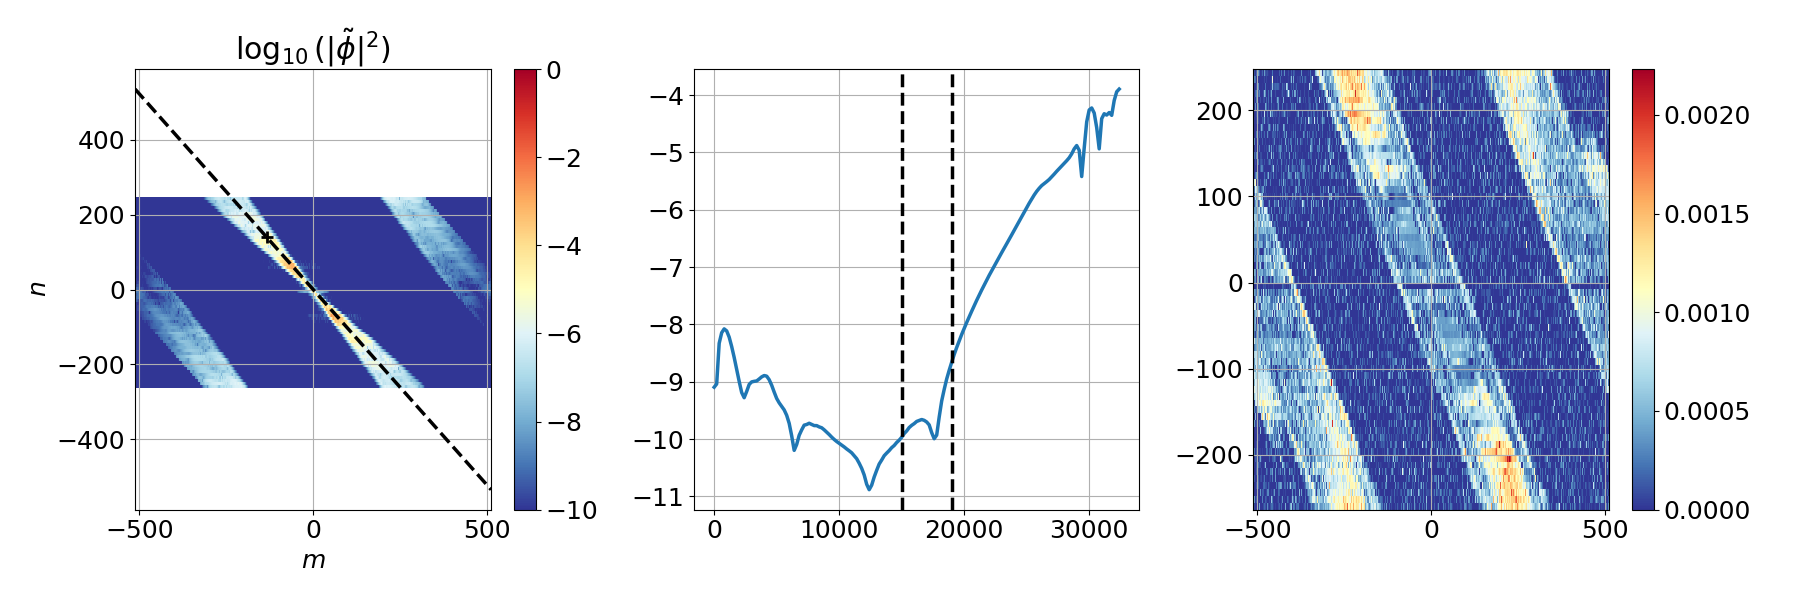

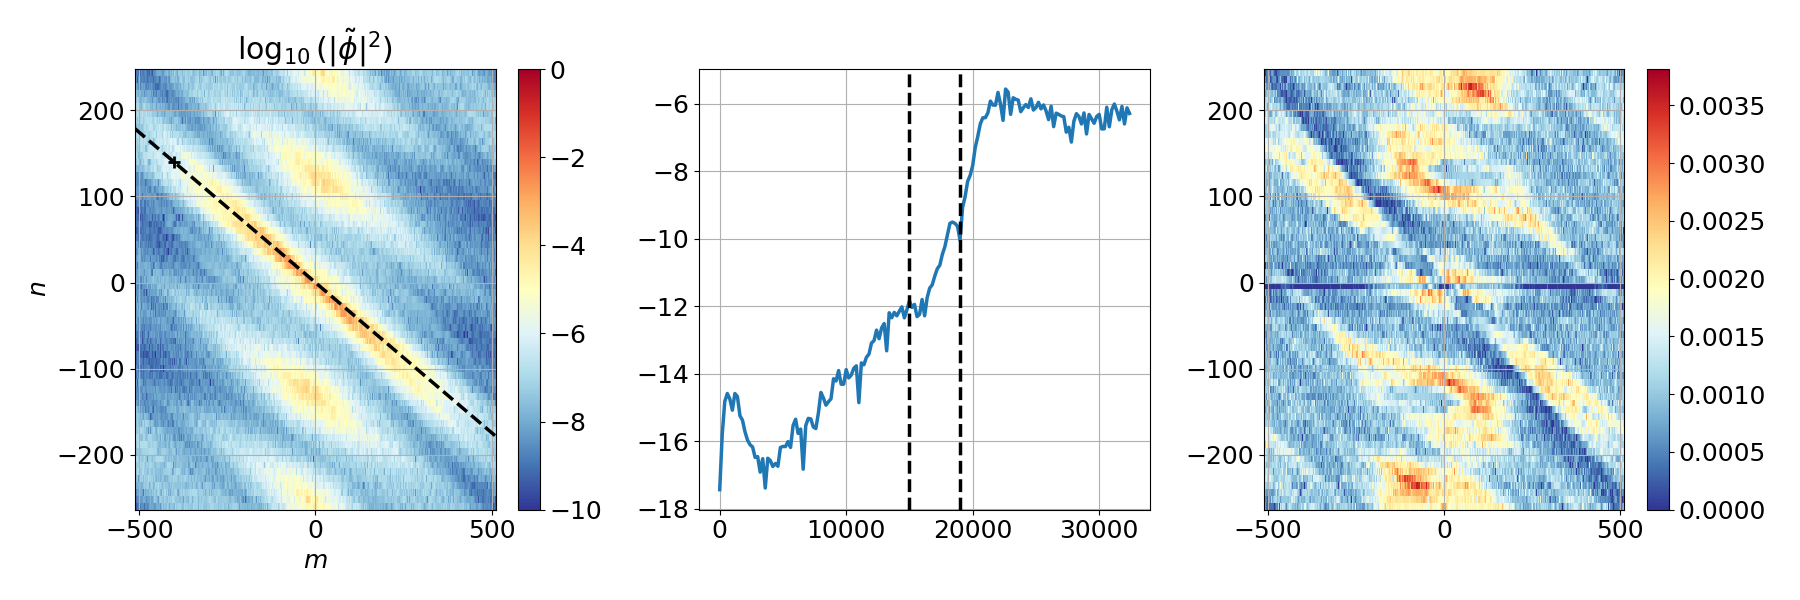

In [3]:
plt.rcParams['axes.formatter.limits'] = (-5,6)

q05_spectra = hdf5_to_dict("data/q05_growthrate_2Dspectra.hdf5")
q15_spectra = hdf5_to_dict("data/q15_growthrate_2Dspectra.hdf5")

print(q05_spectra.keys())

def Fourier2D(F0, y0, x0):

    """ Personal FFT2D function"""

    nx0 = len(x0)
    nx  = 2 * int(nx0 / 2)
    hnx = int(nx / 2)
    ny0 = len(y0)
    ny  = 2 * int(ny0 / 2)
    hny = int(ny / 2)

    x = x0[0:nx]
    y = y0[0:ny]
    F = F0[0:ny, 0:nx]

    Lx   = x[nx - 1] - x[0]
    dx   = x[1] - x[0]
    dkx  = 2. * np.pi / (Lx + dx)
    kx   = np.zeros(nx)
    temp = -dkx * np.r_[1:hnx + 1]
    kx[0:hnx]  = temp[::-1]
    kx[hnx:nx] = dkx * np.r_[0:hnx]

    Ly   = y[ny - 1] - y[0]
    dy   = y[1] - y[0]
    dky  = 2. * np.pi / (Ly + dy)
    ky   = np.zeros(ny)
    temp = -dky * np.r_[1:hny + 1]
    ky[0:hny]  = temp[::-1]
    ky[hny:ny] = dky * np.r_[0:hny]

    TFF = np.zeros((ny, nx), dtype=complex)
    AA  = np.zeros((ny, nx), dtype=complex)
    var = np.conjugate(np.fft.fft2(np.conjugate(F))) / float((nx * ny))

    AA[:, 0:hnx]   = var[:, hnx:nx]
    AA[:, hnx:nx]  = var[:, 0:hnx]
    TFF[0:hny, :]  = AA[hny:ny, :]
    TFF[hny:ny, :] = AA[0:hny, :]

    return TFF, kx, ky

for iq,q in enumerate([q05_spectra,q15_spectra]):
    print('qrpeak = %.2f' % q['q_rpeak'])
    phi2D = q['Phithphi']**2

    Nphi = len(q['phig'])-1
    Ntheta = len(q['thetag'])-1

    tevol_TFPhi2D = np.zeros((len(q['time']),Nphi,Ntheta))

    for it in range(len(q['time'])):
        tevol_TFPhi2D[it,:,:] = np.abs(Fourier2D(phi2D[it,0:Nphi+1,0:Ntheta+1],q['phig'],q['thetag'])[0])

    m2d,n2d = Fourier2D(phi2D[-1,0:Nphi+1,0:Ntheta+1],q['phig'],q['thetag'])[1:]
    dm2d = (m2d[1]-m2d[0])//2 ; m2d = m2d-dm2d
    dn2d = (n2d[1]-n2d[0])//2 ; n2d = n2d-dn2d

    ## Calculate the linear growth rate between tinit and tend
    tinit = 15e3
    tend  = 19e3

    itinit = np.argmin(np.abs(q['time']-tinit))
    itend  = np.argmin(np.abs(q['time']-tend))

    Gammalin2D = np.log(tevol_TFPhi2D[itend,:,:]/tevol_TFPhi2D[itinit,:,:])/(tend-tinit)

    C = 140
    n_ex = np.argmin(np.abs(n2d-dn2d-C))
    m_ex = np.argmin(np.abs(m2d-dm2d+C*q['q_rpeak']))

    fig = plt.figure(figsize=(18,6))

    ## Plot the 2D spectrum
    ax1 = fig.add_subplot(131)
    p1 = ax1.pcolormesh(m2d,n2d,np.log10(tevol_TFPhi2D[-30,:,:]),vmin=-10,vmax=0)    
    fig.colorbar(p1)
    ax1.set_xlabel(r'$m$')
    ax1.set_ylabel(r'$n$')
    ax1.set_title(r'$\log_{10}(|\tilde{\phi}|^2)$')
    ax1.plot(m2d,-m2d/q['q_rpeak'],c='k',ls='--')
    ## Add the point n_ex,m_ex to the plot
    ax1.plot(m2d[m_ex],n2d[n_ex],'r+')

    ## Plot the time evolution of the spectrum at n_ex,m_ex
    ax2 = fig.add_subplot(132)
    ax2.plot(q['time'],np.log10(tevol_TFPhi2D[:,n_ex,m_ex]))
    ax2.axvline(tinit,c='k',ls='--')
    ax2.axvline(tend,c='k',ls='--')

    ## Plot the growth rate
    ax3 = fig.add_subplot(133)
    p3 = ax3.pcolormesh(m2d,n2d,Gammalin2D[:,:],vmin=0) 
    fig.colorbar(p3)

    fig.tight_layout()


<a id='en_cours_spectre_taux_croissance'></a>
## <font color='coral'>**Travail en cours**</font> - Spectre du taux de croissance [▲](#sommaire)

dict_keys(['Phithphi', 'T_rpeak', 'Tir', 'growth_rate_spectra', 'm', 'n', 'phig', 'q_rpeak', 'rpeak', 'thetag', 'time'])


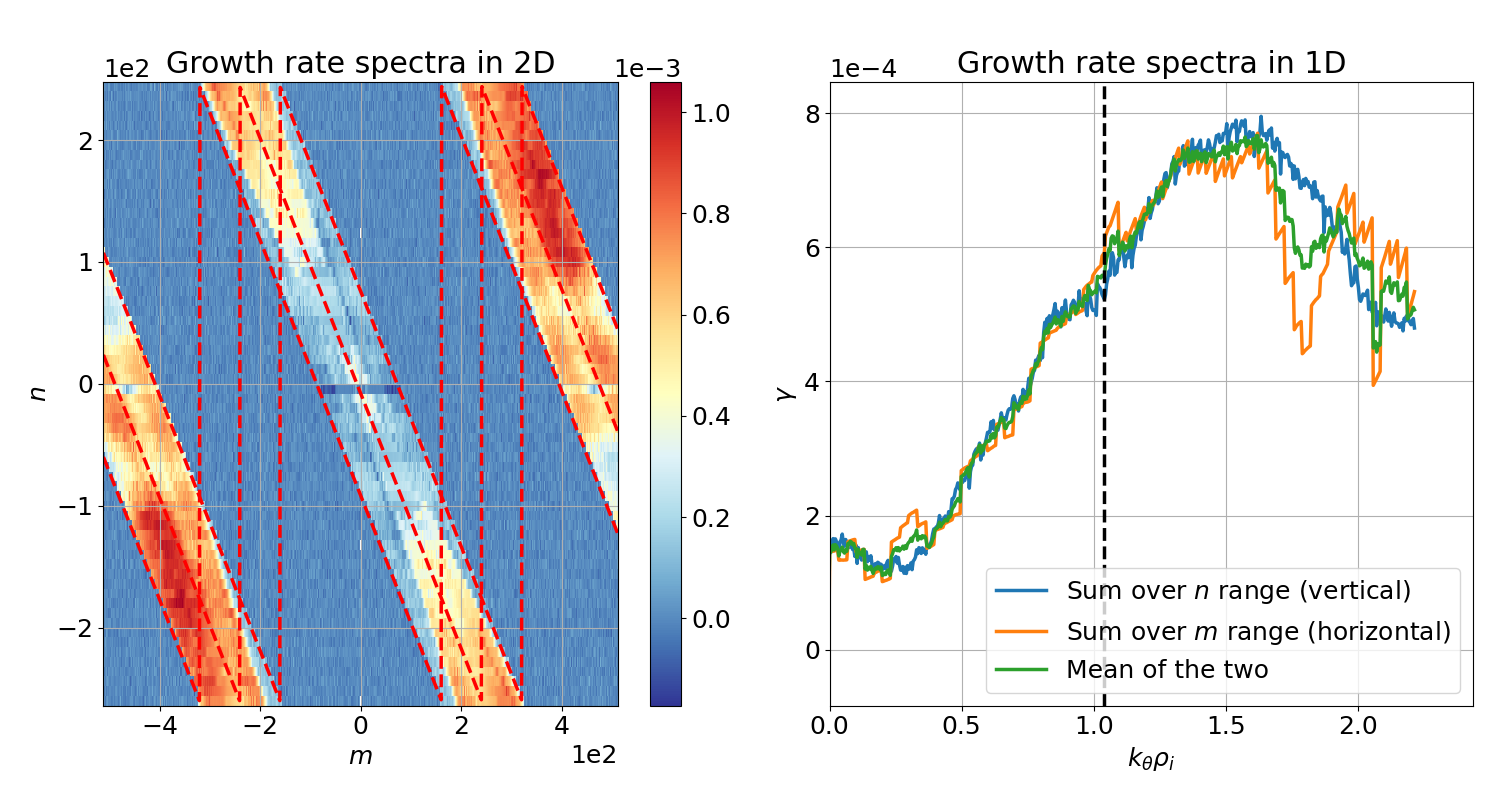

In [7]:
q05_spectra = hdf5_to_dict("data/q05_growthrate_2Dspectra.hdf5")
print(q05_spectra.keys())

nsize = np.abs(q05_spectra['n'][-1] - q05_spectra['n'][0])
dn    = np.abs(q05_spectra['n'][1] - q05_spectra['n'][0])
dm    = np.abs(q05_spectra['m'][1] - q05_spectra['m'][0])
m     = q05_spectra['m']
q     = q05_spectra['q_rpeak']

## Plot the growth rate spectra in 2D
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax1.set_title("Growth rate spectra in 2D")
ax1.set_xlabel(r"$m$")
ax1.set_ylabel(r"$n$")

p = ax1.pcolormesh(q05_spectra['m'],q05_spectra['n'],q05_spectra['growth_rate_spectra'])
fig.colorbar(p)

tol = 80

## Plot lines of constant n=-m/q and range to cover
n = (-m/q + nsize/2)%nsize - nsize/2 - dn
ax1.plot(m, n, ls='--', c='r')
ax1.plot(m, ((-m-tol)/q + nsize/2)%nsize - nsize/2 - dn, ls='--', c='r')
ax1.plot(m, ((-m+tol)/q + nsize/2)%nsize - nsize/2 - dn, ls='--', c='r')

## Plot the growth rate spectra in 1D taking all mode on the n=-m/q line
growth_rate1D_n = np.zeros(len(q05_spectra['m']))
growth_rate1D_m = np.zeros(len(q05_spectra['m']))
for im in range(len(q05_spectra['m'])):
    growth_rate1D_n[im] = np.mean(q05_spectra['growth_rate_spectra'][
                    np.where((q05_spectra['n'] >= n[im]-tol) & (q05_spectra['n'] <= n[im]+tol)), im]
                    )
    growth_rate1D_m[im] = np.mean(q05_spectra['growth_rate_spectra'][np.argmin(np.abs(q05_spectra['n'] - n[im])),
                    np.where((q05_spectra['m'] >= m[im]-tol) & (q05_spectra['m'] <= m[im]+tol))]
                    )

## Plot the growth rate spectra in 1D
ktheta_rhoi = (m / q05_spectra['rpeak']) * np.sqrt(q05_spectra['T_rpeak']/2)

im_lim = np.argmin(np.abs(q05_spectra['m'] - 240)) 

ax2 = fig.add_subplot(122)
ax2.set_title("Growth rate spectra in 1D")
ax2.set_xlabel(r"$k_\theta \rho_i$")
ax2.set_ylabel(r"$\gamma$")
ax2.plot(ktheta_rhoi,growth_rate1D_n, label=r'Sum over $n$ range (vertical)')
ax2.plot(ktheta_rhoi,growth_rate1D_m, label=r'Sum over $m$ range (horizontal)')
ax2.plot(ktheta_rhoi,(growth_rate1D_n+growth_rate1D_m)/2, label=r'Mean of the two')
ax2.axvline(x=ktheta_rhoi[im_lim], ls='--', c='k')
ax2.set_xlim(left=0)
ax2.legend()
fig.tight_layout()




<a id='resultat_rprof_safety_factor'></a>
## <font color='red'>**Résultat**</font> - Profil radial du **facteur de sécurité** $q$ [▲](#sommaire)

In [ ]:
plt.rc('font',size=20)
#q_ar = [qprof_05,qprof_1,qprof_15]
q_ar = all_sim

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
#ax1.set_title('Safety factor')
for iq,q in enumerate(q_ar):
    irhomin, irhomax = np.searchsorted(q['rho'],[0.2,1.0])

    irho = (np.abs(q['rho'] - 0.95 )).argmin()
    ax1.plot(q['rho'][irhomin:irhomax], q['q'][irhomin:irhomax], label=q['title']+r', $q_{95} = %.1f$' % q['q'][irho],c=q['c'],lw=4,marker=q['marker'],markevery=me)
ax1.legend()
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$q$')
ax1.axvline(x=1,ls='--',c='k'); ax1.axhline(y=0,ls='--',c='k')
ax1.set_xlim(left=q['rho'][irhomin],right=q['rho'][irhomax])

ax1.axhline(y=1,c='g',ls='-.',lw=3)
ax1.text(x=0.9, y=0.9, s=r'$q=1$', verticalalignment='top',c='g')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.set_size_inches(8, 8)
fig.savefig('Figures/rprof_q_profiles.pdf', format='pdf', bbox_inches='tight')

<a id='resultat_rprof_reynolds_stress'></a>
## <font color='red'>**Résultat**</font> - Profil radial du **tenseur de Reynolds $\Pi_{r \theta}$** (moyenné en temps **et** coarse-grained) [▲](#sommaire)

In [ ]:
q_ar = [qprof_05,qprof_1,qprof_15]

fig = plt.figure(figsize=(8,8))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)

N=60
def u1d(X):return uniform_filter1d(uniform_filter1d(X,size=N),size=N)

def g1d(X):
    return gaussian_filter1d(X,sigma=N)

for iq,q in enumerate(q_ar):
    
    irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])
    itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])
    
    ax1.plot(q['rho'][irhomin:irhomax], np.mean(q['RSpol'][itmin:itmax,irhomin:irhomax],axis=0),ls='--',c=q['c'],lw=2)
    ax1.plot(q['rho'][irhomin:irhomax], u1d(np.mean(q['RSpol'][itmin:itmax,irhomin:irhomax],axis=0)),c=q['c'],label=q['title'],lw=4)

    ax1.axhline(y=0,ls='--',c='k')

ax1.set_ylabel(r'$\Pi_{r \theta}$ $[V_{T0}^2]$')

ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)

ax1.legend(loc='lower right')
ax1.set_xlabel(r'$r/a$')

plt.text(x=0.01, y=0.9, s='Plain: coarse-grained \ndashed: time average only', transform=ax1.transAxes)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/rprof_RSpol_scanq.pdf', format='pdf', bbox_inches='tight')

<a id='resultat_rprof_div_reynolds_stress'></a>
## <font color='red'>**Résultat**</font> - Profil radial du **coarse-grained $- \nabla \cdot \Pi_{r_\theta}$ avec une fenêtre radiale de $\sim 40 \rho_i$** [▲](#sommaire)

In [ ]:
q_ar = [qprof_05,qprof_1,qprof_15]

param_ar = ['drRSpol_vE']

N=60
Ng=30

for ip,p in enumerate(param_ar):
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    for iq,q in enumerate(q_ar):

        irhomin, irhomax = np.searchsorted(q['rho'],[0.0,1.0])
        itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])
        
        p_ma = uniform_filter1d(uniform_filter1d(np.mean(q[p][itmin:itmax,irhomin:irhomax],axis=0),size=N),size=N)
        p_ga = gaussian_filter1d(np.mean(q[p][itmin:itmax,:],axis=0),sigma=Ng)[irhomin:irhomax]
        
        ax1.plot(q['rho'][irhomin:irhomax], -p_ma, label=q['title'],lw=3,c=q['c'], ls='-')
        ax1.axhline(y=0,c='k',ls='--')
        
        
    ax1.legend()
    ax1.set_xlabel(r'$r/a$')
    ax1.set_ylabel(r'$-\langle \nabla \cdot \Pi_{r \theta} \rangle_{CG}$')
    
    fig.tight_layout()
    
    fig.savefig('Figures/rprof_divPiCG_scanq.pdf', format='pdf', bbox_inches='tight')

<a id='resultat_qscan_div_reynolds_stress'></a>
## <font color='red'>**Résultat**</font> - Profil en $q$ du **coarse-grained $- \nabla \cdot \Pi_{r_\theta}$** [▲](#sommaire)

In [ ]:
q_ar = [qprof_05,qprof_1,qprof_15]

param_ar = ['drRSpol_vE']

N=60
Ng=30

for ip,p in enumerate(param_ar):
    fig = plt.figure(figsize=(8,6))
    #fig.suptitle(p)
    ax1 = fig.add_subplot(111)
    for iq,q in enumerate(q_ar):

        irhomin, irhomax = np.searchsorted(q['rho'],[0.79,0.81])
        itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])
        
        p_ma = uniform_filter1d(uniform_filter1d(np.mean(q[p][itmin:itmax,:],axis=0),size=N),size=N)
        p_ga = gaussian_filter1d(np.mean(q[p][itmin:itmax,:],axis=0),sigma=Ng)[irhomin:irhomax]
        
        ax1.plot(q['q'][irhomin:irhomax], -p_ma[irhomin:irhomax], lw=3,c=q['c'], marker='s',ls='', label=q['title'])
        
        #ax1.plot(q['q'][irhomin:irhomax], 0.3e-7*(-1+q['q'][irhomin:irhomax])**(1/3), c=q['c'])
        
        ax1.axhline(y=0,c='k',ls='--')
        
#     ax1.plot(q['rho'][40:40+Ng],np.ones(Ng)*-0.02,c='k')
#     ax1.plot(q['rho'][100:100+N],np.ones(N)*-0.02,c='k')
        
    
    ax1.set_xlabel(r'$q$')
    ax1.set_xlim(0,5)
    ax1.set_ylabel(r'$-\langle \nabla \cdot \Pi_{r \theta} \rangle_{CG}$ in $%.2f < r/a < %.2f$' %(q['rho'][irhomin], q['rho'][irhomax]) )
    
    qrange = np.linspace(0,5,100)
    ax1.plot(qrange, 0.45e-7*(-1+qrange)**(1/3), c='g', label=r'$C (-1+q)^{1/3}$')
    
    ax1.legend()
    
    fig.savefig('Figures/qprof_divPi_08.pdf', format='pdf', bbox_inches='tight')

<a id='resultat_rprof_flows'></a>
## <font color='red'>**Résultat**</font> - Profil radial des **flows ($E_r, V_P, V_T$)** [▲](#sommaire)

In [ ]:
plt.rcParams['axes.formatter.limits'] = (-5,6)
plt.rc('font',size=20)
q_ar = [qprof_05,qprof_1,qprof_15]
#q_ar = [qprof_05_n0,qprof_15_n0]

param_ar = ['Er','VT','VP']

title_ar = [r'$E_r[V_{T_0} B_0]$',r'$V_P$',r'$V_T$']

y_min_ar = [-2.5e-2, -6e-2, 4e-3]
y_max_ar = [-1e-2, 0, -3.5e-3]

for ip,p in enumerate(param_ar):
    fig = plt.figure(figsize=(8,8))
    #fig.suptitle(p)
    ax1 = fig.add_subplot(111)
    for iq,q in enumerate(q_ar):

        irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])
        itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])
        
        ax1.plot(q['rho'][irhomin:irhomax], np.mean( q[p][itmin:itmax,irhomin:irhomax],axis=0),ls=q['ls'],c=q['c'],lw=4,label=q['title'],marker=q['marker'],markevery=me)
        #ax1.plot(q['rho'][irhomin:irhomax], np.mean( q[p][itmin:itmax,irhomin:irhomax],axis=0) /q['q'][irhomin:irhomax],ls='--',c=q['c'],label=q['title'])
        
        ax1.axhline(y=0,ls='--',c='k')
        
    ax1.set_ylabel(title_ar[ip])
    ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)
        
    ax1.legend()
    ax1.set_xlabel(r'$r/a$')
    
    ax1.axvline(x=1,ls='--',c='k')

    ax1.set_xlim(left=q['rho'][irhomin],right=q['rho'][irhomax])

    #ax1.text(x=0.7,y=(y_min_ar[ip]+y_max_ar[ip])/2.,s=r"$\nearrow I_P$",fontsize=18,c='g')
    
    #ax1.annotate("", xy=(0.8, y_min_ar[ip]), xytext=(0.8, y_max_ar[ip]),arrowprops=dict(width=5,facecolor='none',edgecolor='g'),horizontalalignment='center', verticalalignment='center')
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    fig.set_size_inches(8, 8)
    fig.savefig('Figures/rprof_'+p+'_scanq.pdf', format='pdf', bbox_inches='tight')

<a id='resultat_rprof_nutheta_gianakon'></a>
## <font color='red'>**Résultat**</font> - Profil radial de la friction néoclassique $\nu_\theta$ empirique tiré de *Gianakon PoP 2002, p12, Eq(C16)* [▲](#sommaire)

In [ ]:
q_ar = [qprof_05,qprof_1,qprof_15]

fig = plt.figure(figsize=(7,7))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)

N=60
def u1d(X):return uniform_filter1d(uniform_filter1d(X,size=N),size=N)
def g1d(X):return gaussian_filter1d(X,sigma=N)

for iq,q in enumerate(q_ar):
    irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])
    itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])

    #Calcul de la friction NC poloidale (cf Gianakon 2002)
    nutheta = (0.452 * np.sqrt(2*q['eps']) * q['nu_i'])/( (1+1.03*q['nustar']**(1/2) +0.31 * q['nustar']) * (1 + 0.66 * q['nustar'] * q['eps']**(3/2))) * (q['q']/q['eps'])**2

    ax1.plot(q['rho'][irhomin:irhomax], np.mean(nutheta[itmin:itmax,irhomin:irhomax],axis=0),ls=q['ls'],c=q['c'],label=q['title'])

    ax1.axhline(y=0,ls='--',c='k')

ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)

ax1.legend()
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$\nu_\theta$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#fig.savefig('Figures/rprof_Pionq_scanq.pdf', format='pdf', bbox_inches='tight')

<a id='resultat_rprof_turb_int'></a>
## <font color='red'>**Résultat**</font> - Profil radial de **l'intensité turbulente $\mathcal{I}$** [▲](#sommaire)

In [ ]:
plt.rcParams['axes.formatter.limits'] = (-5,6)
plt.rc('font',size=20)
#q_ar = [qprof_05,qprof_1,qprof_15]

q_ar = all_sim

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

for iq,q in enumerate(q_ar):
    
    irhomin, irhomax = np.searchsorted(q['rho'],[0.2,1.0])
    itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])

    ax1.plot(q['rho'][irhomin:irhomax], np.sqrt(np.mean( (q['Isq'])[itmin:itmax,irhomin:irhomax],axis=0)),ls=q['ls'],c=q['c'],lw=4,label=q['title'],marker=q['marker'],markevery=me)

    ax1.axhline(y=0,ls='--',c='k')

ax1.set_ylabel(r'$\mathcal{I}$')

ax1.legend(loc='upper left',fontsize=18)
ax1.set_xlabel(r'$r/a$')
ax1.set_xlim(left=q['rho'][irhomin],right=q['rho'][irhomax])

ax1.axvline(x=1,ls='--',c='k')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/rprof_turb_intens_scanq.pdf', format='pdf', bbox_inches='tight')

<a id='resultat_rprof_ion_collision_freq'></a>
## <font color='red'>**Résultat**</font> - Profil radial de la **fréquence de collision ionique $\nu_i$** [▲](#sommaire)

In [ ]:
plt.rcParams['axes.formatter.limits'] = (-5,6)
q_ar = [qprof_05,qprof_1,qprof_15]

param_ar = ['turb_int_sq_avg']

title_ar = [r'$\mathcal{I}$']

fig = plt.figure(figsize=(6,6))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)

for iq,q in enumerate(q_ar):
    irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])
    itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])

    ax1.plot(q['rho'][irhomin:irhomax], np.mean( (q['nu_i'])[itmin:itmax,irhomin:irhomax],axis=0),ls=q['ls'],c=q['c'],label=q['title'],lw=4)

    ax1.axhline(y=0,ls='--',c='k')

ax1.set_ylabel(r'$\nu_i$ $[\omega_{c0}]$')
#ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)

ax1.legend()
ax1.set_xlabel(r'$r/a$')

ax1.axvline(x=1,ls='--',c='k')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/rprof_nu_i.pdf', format='pdf', bbox_inches='tight')

<a id='resultat_validation_approx_ptransfert'></a>
## <font color='red'>**Résultat**</font> - Validation de la simplification sur la **puissance $\mathcal{P} = \langle - \nabla \cdot \Pi_{r\theta} \rangle V_E$** [▲](#sommaire)
Dans la littérature, il est souvent fait l'approximation $\int_0^{r_0} \langle - \nabla \cdot \Pi_{r\theta} \rangle V_E \approx \int_0^{r_0} -\langle \Pi_{r\theta} \rangle \partial_r V_E$.
On s'attend à ce que ce soit vrai pour un $r_0$ suffisement grand.
Dans nos simulations, il faut $r_0 \sim 40 \rho_i$ pour que ça marche.

In [ ]:
q_ar = [qprof_05,qprof_15]

for iq,q in enumerate(q_ar):
    #q['Ptransfert'] = -q['dRSpoldr'] * (-q['Er'])
    q['Ptransfert_approx'] = q['RSpol'] * (-q['dErdr'])
    q['Ptransfert_res'] = np.gradient(-q['RSpol'] * (-q['Er']), q['rg'], axis=1) 

param_ar = ['Ptransfert', 'Ptransfert_approx']
label_ar = [r'$\nabla \cdot \Pi_{r\theta} \times V_{E\theta}$', r'$\Pi_{r\theta} \times \partial_r V_{E\theta}$']
    
colors_ar = ['xkcd:blue','xkcd:red','xkcd:purple','xkcd:green']
colors_ar2 = ['xkcd:blue green','xkcd:dark orange','xkcd:bright pink','xkcd:apple green']
    
def update_plot(N,dpi_adjust):
    plt.close('all')

    fig = plt.figure(figsize=(6*len(q_ar),6), dpi=dpi_adjust)
    size_window = N * 250 * 1.3 / len(qprof_05['rg']) 
    fig.suptitle(r'Approximative window size for avg : %.1f $\rho_i$' % size_window )
    for iq,q in enumerate(q_ar):
        
        irhomin, irhomax = np.searchsorted(q['rho'],[0.0,1.0])
        itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])

        ax1 = fig.add_subplot(1,len(q_ar),iq+1)
        ax1.set_title(q['title'])
        for ip,p in enumerate(param_ar):
            ## Plot raw
            ax1.plot(q['rho'][irhomin:irhomax], np.mean(q[p][itmin:itmax,irhomin:irhomax],axis=0), c=colors_ar[ip], lw=1.5, ls='--')

            ## Plot coarse-grained
            ax1.plot(q['rho'][irhomin:irhomax], uniform_filter1d(uniform_filter1d(np.mean(q[p][itmin:itmax,irhomin:irhomax],axis=0),size=N),size=N), label=label_ar[ip],c=colors_ar[ip],lw=3, ls='-')

        ax1.axhline(y=0,c='k',ls='--')
        ax1.legend()
        ax1.set_xlabel(r'$r/a$')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    ax1.plot(q['rho'][10:10+N],np.ones(N)*ax1.get_ylim()[1]/2,c='xkcd:battleship grey',lw=5)

interact(update_plot, **custom_widgets)

<a id='en_cours_evo_eq_terms_er'></a>
## <font color='purple'>**(Old)**</font> <font color='coral'>**Travail en cours**</font> - Analyse des termes dans l'évolution de $E_r$ [▲](#sommaire)

L'équation de conservation de la vorticité généralisée peut se réécrire sous la forme :

$ \huge \partial_t E_r = \frac{B_{eq}^2}{n_{eq} m} J_r - \frac{1}{2} \frac{1}{n_{eq} e} \partial_t ( \nabla_\perp P_\perp ) $

In [ ]:
plt.close('all')

def update_plot(dpi_adjust,float_time,select_sim):
    
    plt.close('all')

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig = plt.figure(figsize=(15,4*len(q_ar)))

    tscan = float_time

    fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    for iq,q in enumerate(q_ar):

        ax_rprof = fig.add_subplot(len(q_ar),2,2*iq+1)

        irhomin, irhomax = np.searchsorted(q['rho'],[0.4,1.0])
        
        itscan = np.searchsorted(q['time'],tscan)
        
        dt_vorticity = np.gradient(q['vorticity'],q['time'],axis=0)
        div_Jr = np.gradient(q['Jr'],q['rg'],axis=1)

        ax_rprof.set_title(q['title'] + ' - Vorticity')
        ax_rprof.plot(q['rho'][irhomin:irhomax], dt_vorticity[itscan,irhomin:irhomax],ls=q['ls'],c='b',label=r'$\partial_t \langle \Omega \rangle$')
        ax_rprof.plot(q['rho'][irhomin:irhomax], -div_Jr[itscan,irhomin:irhomax],ls=q['ls'],c='r',label=r'-$\langle J_r \rangle$')
        #ax_rprof.plot(q['rho'][irhomin:irhomax], (dt_vorticity+q['Jr'])[itscan,irhomin:irhomax],ls=q['ls'],c='r',label=r'Error')
        ax_rprof.set_ylim(-4e-6,4e-6)

        ax_rprof2 = fig.add_subplot(len(q_ar),2,2*iq+2)
        
        dt_P = np.gradient(q['P'],q['time'],axis=0)

        ax_rprof2.set_title(q['title'] + ' - Integrated vorticity')
        ax_rprof2.plot(q['rho'][irhomin:irhomax], dt_P[itscan,irhomin:irhomax],ls=q['ls'],c='b',label=r'$\partial_t \langle P \rangle$')
        ax_rprof2.plot(q['rho'][irhomin:irhomax], -q['Jr'][itscan,irhomin:irhomax],ls=q['ls'],c='r',label=r'-$\langle J_r \rangle $')
        #ax_rprof.plot(q['rho'][irhomin:irhomax], (dt_vorticity+q['Jr'])[itscan,irhomin:irhomax],ls=q['ls'],c='r',label=r'Error')
        ax_rprof2.set_ylim(-1e-5,1e-5)

        for axes in [ax_rprof,ax_rprof2]:
            axes.set_xlabel(r'$r/a$')
            axes.axhline(y=0,c='k',ls='--')
            axes.axvline(x=1,c='k',ls='--')
            if iq==0:axes.legend()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    
float_time_slider  = widgets.FloatSlider(value=90e3, min=0, max=150e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time = float_time_slider,
         **custom_widgets
        )

<a id='en_cours_cons_vorticity'></a>
## <font color='purple'>**(Old)**</font> <font color='coral'>**Travail en cours**</font> - Conservation de la vorticité généralisée [▲](#sommaire)

/!\ Problème probable ici: la vorticité a été calculée en utilisant $B(r,\theta)$ et $n(t,r,\theta)$ alors qu'il faut plutôt utiliser $B_0$ et $n(t=0,r)$

In [ ]:
plt.close('all')

def update_plot(dpi_adjust,float_time,float_range_rho,select_sim,
                vorticity_bool,current_bool,density_bool,same_y_range):
    
    plt.close('all')
    clear_output

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig = plt.figure(figsize=(15,6*len(q_ar)))

    tscan = float_time
    rhomin,rhomax = float_range_rho

    fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    for iq,q in enumerate(q_ar):

        ax_rprof = fig.add_subplot(len(q_ar),2,2*iq+1)

        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
        
        itscan = np.searchsorted(q['time'],tscan)
        
        dt_vorticity = np.gradient(q['vorticity'],q['time'],axis=0)
        div_Jr       = np.gradient(q['Jr'],q['rg'],axis=1)

        ax_rprof.set_title(q['title'] + ' - Vorticity')
        if vorticity_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], dt_vorticity[itscan,irhomin:irhomax],c='b',label=r'$\partial_t \langle \Omega \rangle$')
        if current_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], -div_Jr[itscan,irhomin:irhomax],c='r',ls='--',label=r'-$\langle \nabla \cdot J_r \rangle$')
        if density_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], q['dndt'][itscan,irhomin:irhomax],c='g',label=r'$\partial_t n$')
        #ax_rprof.plot(q['rho'][irhomin:irhomax], (dt_vorticity+q['Jr'])[itscan,irhomin:irhomax],ls=q['ls'],c='r',label=r'Error')
        if same_y_range:ax_rprof.set_ylim(-4e-6,4e-6)

        ax_rprof2 = fig.add_subplot(len(q_ar),2,2*iq+2)
        
        dt_P = np.gradient(q['P'],q['time'],axis=0)
        int_dndt = np.cumsum(q['dndt'][:,irhomin:irhomax],axis=1)
        print(int_dndt.shape)
                             
        ax_rprof2.set_title(q['title'] + ' - Integrated vorticity')
        if vorticity_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], dt_P[itscan,irhomin:irhomax],c='b',label=r'$\partial_t \langle P \rangle$')
        if current_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], -q['Jr'][itscan,irhomin:irhomax],c='r',label=r'-$\langle J_r \rangle $')
        if density_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], int_dndt[itscan,:],c='g',label=r'$\int_{r_0}^r \partial_t n$')
        #ax_rprof.plot(q['rho'][irhomin:irhomax], (dt_vorticity+q['Jr'])[itscan,irhomin:irhomax],ls=q['ls'],c='r',label=r'Error')
        if same_y_range:ax_rprof2.set_ylim(-1e-5,1e-5)

        for axes in [ax_rprof,ax_rprof2]:
            axes.set_xlabel(r'$r/a$')
            axes.axhline(y=0,c='k',ls='--')
            axes.axvline(x=1,c='k',ls='--')
            if iq==0:axes.legend()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_time_slider  = widgets.FloatSlider(value=90e3, min=0, max=200e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.1, 1], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time     = float_time_slider,
         float_range_rho  = float_range_rho_slider,
         vorticity_bool = widgets.Checkbox(value=True,description='Display vorticity term'),
         current_bool   = widgets.Checkbox(value=True,description='Display current term'),
         density_bool   = widgets.Checkbox(value=True,description='Display density term'),
         same_y_range   = widgets.Checkbox(value=True,description='Same y range'),
         **custom_widgets
        )

## <font color='royalblue'>**Temporaire**</font> - Fonction porte "smooth" [▲](#sommaire)

In [ ]:
def smoothed_rectangular(x, left, right, k=10):
    """
    Returns a smoothed rectangular function with smoothed discontinuities.
    
    Parameters:
        x (array-like): The independent variable.
        left (float): The left edge of the rectangular function.
        right (float): The right edge of the rectangular function.
        k (float): Controls the steepness of the sigmoid function. Higher k leads to sharper transition.
        
    Returns:
        y (array-like): The smoothed rectangular function evaluated at x.
    """
    y = 1 / (1 + np.exp(-k * (x - left))) - 1 / (1 + np.exp(-k * (x - right)))
    return y

# Example usage
x = np.linspace(-10, 10, 1000)
y = smoothed_rectangular(x, -9, 9, k=10)
plt.figure()
plt.plot(x, y)
plt.show()

## <font color='royalblue'>**Temporaire**</font> - Test de classe de simulation [▲](#sommaire)

In [ ]:
plt.close('all')

## Define a class that init as a dictionnary already existing
class dict2class(dict):
    def __init__(self, *args, **kwargs):
        super(dict2class, self).__init__(*args, **kwargs)
        self.__dict__ = self

    ## Define a method that calculate the gradient relative to the dictionnary keys 'rg'
    def gradr(self, key):
        return np.gradient(self[key], self['rg'], axis=1)
    
    ## Define a method that calculate the gradient relative to the dictionnary keys 'time'
    def gradt(self, key):
        return np.gradient(self[key], self['time'], axis=0)
    
    ## Define a method to plot radial profile of a given key
    def plot_rprof(self, key, ax=None, **kwargs):
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self['rho'], self[key][-1,:], **kwargs)
        ax.set_xlabel(r'$r/a$')
        ax.set_ylabel(r'$%s$' % key)
        return ax
    
    ## Add a method that activate when a certain key is called
    # def __getitem__(self, key):
    #     print('test')
    #     if key == 'drnustar':
    #         return self['nustar'] * 2
    #     else:
    #         return super().__getitem__(key)
        
    ## Add a method to calculate the gradient of any key when the key "dr + key" is called
    def __getitem__(self, key):
        if key[:2] == 'dr':
            return np.gradient(self[key[2:]], self['rg'], axis=1)
        if key[:2] == 'dt':
            return np.gradient(self[key[2:]], self['time'], axis=0)
        else:
            return super().__getitem__(key)
    
## Testing the class
qtest = dict2class(all_sim[0])
print(qtest.gradr('Er'))

## Plotting the gradient
plt.figure()
ax1 = plt.subplot(121)
ax1.pcolormesh(qtest['rg'], qtest['time'], qtest.gradr('Er'))
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$t$')
ax1.set_title(r'$\partial_r E_r$')

ax2 = plt.subplot(122)
ax2.pcolormesh(qtest['rg'], qtest['time'], qtest.gradt('Er'))
ax2.set_xlabel(r'$r/a$')
ax2.set_ylabel(r'$t$')
ax2.set_title(r'$\partial_t E_r$')

#qtest.plot_rprof('Er', label='Er')

plt.figure()
plt.plot(qtest['rho'], qtest['RSpol'][-1,:])
plt.plot(qtest['rho'], qtest['drdrRSpol'][-1,:])

qtest['newtest'] = 'test_reussi'

print(qtest['newtest'])
